In [136]:
import numpy as np
import pandas as pd
import xarray as xr
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import statsmodels.formula.api as smf
from tqdm import tqdm
from datetime import datetime
import pickle 
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import os 



# Remit

In [137]:
# Ordnerpfad zu den CSV-Dateien
csv_folder = 'data/Json_Dateien'

# Leere Liste zum Speichern der DataFrames
dataframes = []

# Alle CSV-Dateien im Ordner einlesen
for filename in os.listdir(csv_folder):
    if filename.endswith('.csv'):
        csv_file = os.path.join(csv_folder, filename)  # Vollständiger Pfad zur CSV-Datei
        df = pd.read_csv(csv_file)  # Einlesen der CSV-Datei
        dataframes.append(df)  # Hinzufügen des DataFrames zur Liste

# Alle DataFrames zu einem einzigen DataFrame zusammenführen
df = pd.concat(dataframes, ignore_index=True)

In [138]:
df['publishTime'] = pd.to_datetime(df['publishTime'])
df['createdTime'] = pd.to_datetime(df['createdTime'])

# Versuche, 'eventStatus' und 'eventStartTime' in Datetime-Objekte zu konvertieren; ungültige Werte werden in NaT umgewandelt
df['eventStatus'] = pd.to_datetime(df['eventStatus'], errors='coerce')
df['eventStartTime'] = pd.to_datetime(df['eventStartTime'], errors='coerce')
df['eventEndTime'] = pd.to_datetime(df['eventEndTime'], errors='coerce')


df['eventTime'] = df['eventEndTime'] - df['eventStartTime']

C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\717224300.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['eventStatus'] = pd.to_datetime(df['eventStatus'], errors='coerce')


In [139]:
df_ff = df.filter(['publishTime','assetId','cause','eventTime'])
df_ff

publishTime    assetId                cause       eventTime
0   2020-11-26 13:54:00+00:00  T_HOWAO-2       Planned Outage 0 days 09:00:00
1   2020-12-10 16:12:00+00:00  T_HOWAO-2       Planned Outage 0 days 10:00:00
2   2020-12-13 19:13:00+00:00  T_HOWAO-2       Planned Outage 0 days 02:00:00
3   2020-12-07 21:19:00+00:00  T_HOWAO-2       Planned Outage 0 days 10:00:00
4   2020-12-14 09:29:00+00:00  T_HOWAO-2       Planned Outage 0 days 03:00:00
..                        ...        ...                  ...             ...
431 2024-09-19 08:33:30+00:00  T_HOWAO-1  Under Investigation 1 days 23:46:00
432 2024-09-20 11:51:24+00:00  T_HOWAO-1  Under Investigation 1 days 21:46:00
433 2024-09-26 09:57:50+00:00  T_HOWAO-1       Planned Outage 6 days 04:00:00
434 2024-09-29 16:45:46+00:00  T_HOWAO-1  Under Investigation 1 days 00:00:00
435 2024-09-29 19:03:50+00:00  T_HOWAO-1  Under Investigation 0 days 04:30:00

[436 rows x 4 columns]

##### Ruden der Zeiten

In [140]:
# Funktion zum Runden auf das nächste 30-Minuten-Intervall
def round_to_nearest_half_hour(dt):
    if dt.minute < 15:
        return dt.replace(minute=0, second=0)
    elif dt.minute < 45:
        return dt.replace(minute=30, second=0)
    else:
        return dt.replace(minute=0, second=0) + pd.Timedelta(hours=1)

# Funktion zum Runden auf die nächste volle Stunde
def round_to_nearest_hour(dt):
    if dt.minute < 30:
        return dt.replace(minute=0, second=0)
    else:
        return dt.replace(minute=0, second=0) + pd.Timedelta(hours=1)

# Anwendung der Rundungsfunktionen auf df_tt
df_ff['rounded_half_hour'] = df_ff['publishTime'].apply(round_to_nearest_half_hour)

df_ff = df_ff.filter(['assetId',	'cause'	,'eventTime',	'rounded_half_hour'	])

In [141]:
df_ff

assetId                cause       eventTime         rounded_half_hour
0    T_HOWAO-2       Planned Outage 0 days 09:00:00 2020-11-26 14:00:00+00:00
1    T_HOWAO-2       Planned Outage 0 days 10:00:00 2020-12-10 16:00:00+00:00
2    T_HOWAO-2       Planned Outage 0 days 02:00:00 2020-12-13 19:00:00+00:00
3    T_HOWAO-2       Planned Outage 0 days 10:00:00 2020-12-07 21:30:00+00:00
4    T_HOWAO-2       Planned Outage 0 days 03:00:00 2020-12-14 09:30:00+00:00
..         ...                  ...             ...                       ...
431  T_HOWAO-1  Under Investigation 1 days 23:46:00 2024-09-19 08:30:00+00:00
432  T_HOWAO-1  Under Investigation 1 days 21:46:00 2024-09-20 12:00:00+00:00
433  T_HOWAO-1       Planned Outage 6 days 04:00:00 2024-09-26 10:00:00+00:00
434  T_HOWAO-1  Under Investigation 1 days 00:00:00 2024-09-29 17:00:00+00:00
435  T_HOWAO-1  Under Investigation 0 days 04:30:00 2024-09-29 19:00:00+00:00

[436 rows x 4 columns]

##### Dummies erstellen

In [142]:
df_ff = pd.get_dummies(df_ff, columns=['assetId','cause'], prefix='Category')

## Dateneinslesen

In [143]:
df_train = pd.read_parquet("df_train.parquet")
df_test = pd.read_parquet("df_test.parquet")

windspeed_train_pca = df_train[["WindSpeed", "WindSpeed:100"]].to_numpy()
windspeed_test_pca = df_test[["WindSpeed", "WindSpeed:100"]].to_numpy()

scale_pca_pipe = Pipeline([
    ("scaling", StandardScaler()),
    ("pca", PCA(n_components=1))
])

windspeed_train_pca = scale_pca_pipe.fit_transform(windspeed_train_pca)
windspeed_test_pca = scale_pca_pipe.transform(windspeed_test_pca)

df_train["WindSpeedPCA"] = windspeed_train_pca
df_test["WindSpeedPCA"] = windspeed_test_pca

winddirection_train_pca = df_train[["WindDirection", "WindDirection:100"]].to_numpy()
winddirection_test_pca = df_test[["WindDirection", "WindDirection:100"]].to_numpy()

winddirection_train_pca = scale_pca_pipe.fit_transform(winddirection_train_pca)
winddirection_test_pca = scale_pca_pipe.transform(winddirection_test_pca)

df_train["WindDirectionPCA"] = winddirection_train_pca
df_test["WindDirectionPCA"] = winddirection_test_pca

In [144]:
# Für jede Spalte mit NaN-Werten:
for column in df_train.columns:
    # Neue Spalte erstellen, die NaN-Werte markiert (1 für NaN, 0 für Werte)
    df_train[f'{column}_missing'] = df_train[column].isna().astype(int)
    # NaN-Werte durch 0 ersetzen
    df_train[column].fillna(0, inplace=True)

C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\1859786724.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[column].fillna(0, inplace=True)
C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\1859786724.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy

In [145]:
# Für jede Spalte mit NaN-Werten:
for column in df_test.columns:
    # Neue Spalte erstellen, die NaN-Werte markiert (1 für NaN, 0 für Werte)
    df_test[f'{column}_missing'] = df_test[column].isna().astype(int)
    # NaN-Werte durch 0 ersetzen
    df_test[column].fillna(0, inplace=True)

C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\1822180193.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[column].fillna(0, inplace=True)
C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\1822180193.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [146]:
# df_train = pd.merge(df_train, df_ff, left_on="valid_time", right_on= 'rounded_half_hour', how ='left')
# df_test = pd.merge(df_test, df_ff, left_on="valid_time", right_on= 'rounded_half_hour', how ='left')

In [147]:
df_train.head()

reference_time                valid_time  RelativeHumidity  \
0 2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00         85.213753   
1 2020-09-20 00:00:00+00:00 2020-09-20 00:30:00+00:00         85.012268   
2 2020-09-20 00:00:00+00:00 2020-09-20 01:00:00+00:00         84.810783   
3 2020-09-20 00:00:00+00:00 2020-09-20 01:30:00+00:00         84.357895   
4 2020-09-20 00:00:00+00:00 2020-09-20 02:00:00+00:00         83.904999   

   temp_hornsea  WindDirection  WindDirection:100  WindSpeed  WindSpeed:100  \
0     15.416670      61.588081          62.085171  10.043627      11.802604   
1     15.412510      61.203667          61.726974   9.905537      11.648818   
2     15.408349      60.819256          61.368782   9.767446      11.495032   
3     15.451218      60.511024          61.111046   9.631038      11.354128   
4     15.494086      60.202793          60.853313   9.494630      11.213223   

   hours_after  CloudCover  ...  temp_x_solar_interaction_missing  \
0          0.0    0.450405  ...                                 0   
1          0.5    0.472211  ...                                 0   
2          1.0    0.494018  ...                                 0   
3          1.5    0.520214  ...                                 0   
4          2.0    0.546410  ...                                 0   

   temp_y_solar_interaction_missing wind_interaction_missing  \
0                                 0                        0   
1                                 0                        0   
2                                 0                        0   
3                                 0                        0   
4                                 0                        0   

   wind_interaction_100_missing  humidity_wind_interaction_missing  \
0                             0                                  0   
1                             0                                  0   
2                             0                                  0   
3                             0                                  0   
4                             0                                  0   

   wind_gradient_missing  CloudCover_lag_1h_missing  \
0                      0                          1   
1                      0                          0   
2                      0                          0   
3                      0                          0   
4                      0                          0   

   cloud_cover_change_missing  WindSpeedPCA_missing  WindDirectionPCA_missing  
0                           1                     0                         0  
1                           0                     0                         0  
2                           0                     0                         0  
3                           0                     0                         0  
4                           0                     0                         0  

[5 rows x 76 columns]

In [148]:
df_train["total_generation_MWh"] = df_train['Wind_MWh_credit'] + df_train['Solar_MWh_credit']
df_test["total_generation_MWh"] = df_test['Wind_MWh_credit'] + df_test['Solar_MWh_credit']

In [149]:
df_train.columns

Index(['reference_time', 'valid_time', 'RelativeHumidity', 'temp_hornsea',
       'WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100',
       'hours_after', 'CloudCover', 'SolarDownwardRadiation', 'temp_solar',
       'dtm', 'MIP', 'Solar_MW', 'Solar_capacity_mwp',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh',
       'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year', 'month',
       'day', 'hour', 'adjusted_solar_radiation', 'temp_x_solar_interaction',
       'temp_y_solar_interaction', 'wind_interaction', 'wind_interaction_100',
       'humidity_wind_interaction', 'wind_gradient', 'CloudCover_lag_1h',
       'cloud_cover_change', 'WindSpeedPCA', 'WindDirectionPCA',
       'reference_time_missing', 'valid_time_missing',
       'RelativeHumidity_missing', 'temp_hornsea_missing',
       'WindDirection_missing', 'WindDirection:100_missing',
       'WindSpeed_missing', 'WindSpeed:100_missing', 'hours_after_missing',
       'CloudCover_missin

In [150]:
df_ff.dtypes

eventTime                           timedelta64[ns]
rounded_half_hour               datetime64[ns, UTC]
Category_T_HOWAO-1                             bool
Category_T_HOWAO-2                             bool
Category_T_HOWAO-3                             bool
Category_Forced Outage                         bool
Category_NonOperator Alert                     bool
Category_Planned Outage                        bool
Category_Turbine                               bool
Category_Under Investigation                   bool
dtype: object

### Vergleichen der Werte von Trainingsdaten und Testdaten

In [151]:
# Spalten, die ausgeschlossen werden sollen
exclude_columns = ['reference_time', 'valid_time',]

# Min und Max im Trainings-DataFrame berechnen (nur für die nicht ausgeschlossenen Spalten)
train_min = df_train.drop(columns=exclude_columns).min()
train_max = df_train.drop(columns=exclude_columns).max()

# Eine Liste zum Speichern der Indizes der gültigen Zeilen
valid_indices = set(df_test.index)

# Überprüfen jeder Spalte (nur nicht ausgeschlossene Spalten)
for column in df_test.columns:
    if column not in exclude_columns:
        # Indizes der Zeilen, die die Bedingungen für diese Spalte nicht erfüllen
        invalid_rows = df_test[(df_test[column] < train_min[column]) | (df_test[column] > train_max[column])].index
        valid_indices -= set(invalid_rows)

# Bereinigten Test-DataFrame erstellen
df_test_cleaned = df_test.loc[list(valid_indices)]

# Ergebnisse ausgeben
print("Bereinigter Test-DataFrame:")
print(df_test_cleaned)

Bereinigter Test-DataFrame:
                   reference_time                valid_time  RelativeHumidity  \
1048576 2023-09-28 00:00:00+00:00 2023-10-02 17:00:00+00:00         95.041519   
1048577 2023-09-28 00:00:00+00:00 2023-10-02 17:30:00+00:00         95.181107   
1048578 2023-09-28 00:00:00+00:00 2023-10-02 18:00:00+00:00         95.320694   
1048579 2023-09-28 00:00:00+00:00 2023-10-02 18:30:00+00:00         95.101997   
1048580 2023-09-28 00:00:00+00:00 2023-10-02 19:00:00+00:00         94.883308   
...                           ...                       ...               ...   
1048571 2023-09-28 00:00:00+00:00 2023-10-02 14:30:00+00:00         93.892525   
1048572 2023-09-28 00:00:00+00:00 2023-10-02 15:00:00+00:00         94.483177   
1048573 2023-09-28 00:00:00+00:00 2023-10-02 15:30:00+00:00         94.622765   
1048574 2023-09-28 00:00:00+00:00 2023-10-02 16:00:00+00:00         94.762352   
1048575 2023-09-28 00:00:00+00:00 2023-10-02 16:30:00+00:00         94.901932   


In [152]:
# Über alle Spalten iterieren
for column in df_test.columns:
    if column in df_train.columns and column not in ['reference_time', 'valid_time', 'dtm', 'tt']:  # Ausschluss der Spalten
        min_train = df_train[column].min()
        max_train = df_train[column].max()
        
        # Berechnung der Spannweite und ..% der Spannweite
        range_train = max_train - min_train
        ten_percent_range = 0.00 * range_train   # anpassen
        
        # Neue Min- und Max-Grenzen mit ..%
        new_min = min_train - ten_percent_range
        new_max = max_train + ten_percent_range
        
        # Werte in df_test, die zwischen new_min und min_train sowie new_max und max_train liegen
        df_test.loc[(df_test[column] >= new_min) & (df_test[column] <= min_train), column] = min_train
        df_test.loc[(df_test[column] >= max_train) & (df_test[column] <= new_max), column] = max_train

# Ausgabe des aktualisierten DataFrames
display(df_test.head())

reference_time                valid_time  RelativeHumidity  \
1022322 2023-09-01 00:00:00+00:00 2023-09-01 00:00:00+00:00         76.245575   
1022323 2023-09-01 00:00:00+00:00 2023-09-01 00:30:00+00:00         76.467690   
1022324 2023-09-01 00:00:00+00:00 2023-09-01 01:00:00+00:00         76.689804   
1022325 2023-09-01 00:00:00+00:00 2023-09-01 01:30:00+00:00         76.803444   
1022326 2023-09-01 00:00:00+00:00 2023-09-01 02:00:00+00:00         76.917084   

         temp_hornsea  WindDirection  WindDirection:100  WindSpeed  \
1022322     16.375929     154.924484         155.368561   3.577844   
1022323     16.416004     154.937408         155.311554   3.471707   
1022324     16.456081     154.950348         155.254547   3.365570   
1022325     16.507286     150.091034         150.407196   3.361010   
1022326     16.558493     145.231705         145.559830   3.356450   

         WindSpeed:100  hours_after  CloudCover  ...  \
1022322       3.935110          0.0    1.000000  ...   
1022323       3.822476          0.5    0.999918  ...   
1022324       3.709841          1.0    0.999836  ...   
1022325       3.717003          1.5    0.999918  ...   
1022326       3.724164          2.0    1.000000  ...   

         temp_y_solar_interaction_missing  wind_interaction_missing  \
1022322                                 0                         0   
1022323                                 0                         0   
1022324                                 0                         0   
1022325                                 0                         0   
1022326                                 0                         0   

        wind_interaction_100_missing  humidity_wind_interaction_missing  \
1022322                            0                                  0   
1022323                            0                                  0   
1022324                            0                                  0   
1022325                            0                                  0   
1022326                            0                                  0   

         wind_gradient_missing  CloudCover_lag_1h_missing  \
1022322                      0                          0   
1022323                      0                          0   
1022324                      0                          0   
1022325                      0                          0   
1022326                      0                          0   

         cloud_cover_change_missing  WindSpeedPCA_missing  \
1022322                           0                     0   
1022323                           0                     0   
1022324                           0                     0   
1022325                           0                     0   
1022326                           0                     0   

         WindDirectionPCA_missing  total_generation_MWh  
1022322                         0                37.822  
1022323                         0                47.492  
1022324                         0                45.072  
1022325                         0                48.412  
1022326                         0                47.202  

[5 rows x 77 columns]

##### Vergleich der Datensätze

In [154]:
# DataFrame für Ergebnisse erstellen
results = []

# Iteriere durch die Spalten in df_train
for column in df_train.columns:
    if column in df_test.columns:  # Sicherstellen, dass die Spalte in beiden DataFrames vorhanden ist
        min_train = df_train[column].min()
        max_train = df_train[column].max()
        min_test = df_test[column].min()
        max_test = df_test[column].max()
        
        # Bedingung prüfen und True/False setzen
        is_in_range = (min_test >= min_train) and (max_test <= max_train)
        
        # Speichere die Ergebnisse in einer Liste
        results.append({
            'Column': column,
            'Min Train': min_train,
            'Min Test': min_test,
            'Max Test': max_test,
            'Max Train': max_train,
            'In Range': is_in_range  # True/False Ergebnis
        })

# Erstelle ein DataFrame aus den Ergebnissen
results_df = pd.DataFrame(results)

# Ausgabe des neuen DataFrames
display(results_df)


Column                  Min Train  \
0               reference_time  2020-09-20 00:00:00+00:00   
1                   valid_time  2020-09-20 00:00:00+00:00   
2             RelativeHumidity                  47.787594   
3                 temp_hornsea                  -0.474335   
4                WindDirection                   0.740732   
..                         ...                        ...   
72   CloudCover_lag_1h_missing                          0   
73  cloud_cover_change_missing                          0   
74        WindSpeedPCA_missing                          0   
75    WindDirectionPCA_missing                          0   
76        total_generation_MWh                        0.0   

                     Min Test                   Max Test  \
0   2023-09-01 00:00:00+00:00  2023-11-30 18:00:00+00:00   
1   2023-09-01 00:30:00+00:00  2023-12-05 18:00:00+00:00   
2                   52.511944                  99.991806   
3                    4.013238                  20.360867   
4                    2.115113                  357.97464   
..                        ...                        ...   
72                          0                          0   
73                          0                          0   
74                          0                          0   
75                          0                          0   
76                        0.0                1237.004661   

                    Max Train  In Range  
0   2024-05-19 00:00:00+00:00      True  
1   2024-05-19 23:30:00+00:00      True  
2                  100.000549      True  
3                   21.604519      True  
4                  359.364044      True  
..                        ...       ...  
72                          1      True  
73                          1      True  
74                          0      True  
75                          0      True  
76                  1479.6468      True  

[77 rows x 6 columns]

#### Daten Scalieren

In [155]:
exclude_columns = ['Solar_MW','Wind_MW','total_generation_MWh']

# Auswahl der numerischen Spalten, die nicht in der Ausschlussliste sind
numeric_columns = df_train.select_dtypes(include=['float', 'int']).columns.difference(exclude_columns)

# Normalisierung der numerischen Spalten mit MinMaxScaler
scaler = MinMaxScaler()
df_train[numeric_columns] = scaler.fit_transform(df_train[numeric_columns])

In [156]:
exclude_columns = ['Solar_MW','Wind_MW','total_generation_MWh']

# Auswahl der numerischen Spalten, die nicht in der Ausschlussliste sind
numeric_columns = df_train.select_dtypes(include=['float', 'int']).columns.difference(exclude_columns)

# Normalisierung der numerischen Spalten mit MinMaxScaler
scaler = MinMaxScaler()
df_test[numeric_columns] = scaler.fit_transform(df_test[numeric_columns])

In [157]:
df_train.min()

reference_time                2020-09-20 00:00:00+00:00
valid_time                    2020-09-20 00:00:00+00:00
RelativeHumidity                                    0.0
temp_hornsea                                        0.0
WindDirection                                       0.0
                                        ...            
CloudCover_lag_1h_missing                           0.0
cloud_cover_change_missing                          0.0
WindSpeedPCA_missing                                0.0
WindDirectionPCA_missing                            0.0
total_generation_MWh                                0.0
Length: 77, dtype: object

## Modelltraining gesamt

In [158]:
model_formulas = [ 'total_generation_MWh ~ + bs(CloudCover, df=8) \
      + bs(temp_solar, df=10)              \
                + bs(SolarDownwardRadiation, df=8)\
                + bs(temp_x_solar_interaction, df=8)                        \
            + bs(temp_y_solar_interaction, df=13)               \
   + bs(adjusted_solar_radiation, df=15)   \
            + bs(WindSpeedPCA, df=20)          \
      + bs(humidity_wind_interaction, df=10)                      \
              + bs(wind_interaction,df=10)   ']


# Funktion zur Modellierung für die Trainingsdaten
def train_models(df_train):
    forecast_models = dict()  # Dictionary für die trainierten Modelle
    
    # Verwende tqdm für Fortschrittsanzeigen
    for idx, formula in enumerate(model_formulas):
        for quantile in tqdm(range(10, 100, 10), desc=f"Training Modell {idx + 1}", unit="Quantil"):
            # Fitting das Modell für jeden Quantil auf den Trainingsdaten
            mod = smf.quantreg(formula, data=df_train)  # Quantile Regression
            forecast_models[f"Model_{idx + 1}_q{quantile}"] = mod.fit(q=quantile / 100, max_iter=2500)  # Modellanpassung
            
            # Vorhersagen für Trainingsdaten speichern
            df_train[f"Model_{idx + 1}_q{quantile}"] = forecast_models[f"Model_{idx + 1}_q{quantile}"].predict(df_train)
            df_train.loc[df_train[f"Model_{idx + 1}_q{quantile}"] < 0, f"Model_{idx + 1}_q{quantile}"] = 0  # Negative Werte auf 0 setzen
        
    return forecast_models  # Rückgabe der trainierten Modelle

# Funktion zur Berechnung des Pinball Scores
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df, model_idx):
    score = []  # Liste für den Gesamt-Pinball Score
    per_quantile_scores = []  # Liste für die Scores pro Quantil
    for qu in range(10, 100, 10):
        pinball_score_value = pinball(
            # y=df["total_generation_MWh"].fillna(0),  # Zielvariable
            y=df["Solar_MWh_credit"].fillna(0),
            	
            q=df[f"Model_{model_idx}_q{qu}"].fillna(0),  # Vorhersage
            alpha=qu / 100  # Quantil-Wert
        ).mean()
        
        score.append(pinball_score_value)  # Hinzufügen des Scores zur Liste
        per_quantile_scores.append((qu, pinball_score_value))  # Speichern des Scores pro Quantil
    
    overall_score = np.nanmean(score)
    
    return overall_score, per_quantile_scores  # Rückgabe des Gesamtwerts und der Scores pro Quantil

# Funktion zum Berechnen der Pinball Scores und Speichern der Ergebnisse in CSV
def calculate_and_save_scores(training_data, test_data, forecast_models, model_formulas):
    all_scores = []  # Liste für alle Scores
    result_data = []  # Liste für Ergebnisse zum Speichern

    for data_type, data in [("Training", training_data), ("Test", test_data)]:
        for model_idx in range(1, len(model_formulas) + 1):  # Für alle Modelle
            formula = model_formulas[model_idx - 1]  # Die Formel des aktuellen Modells
            for quantile in tqdm(range(10, 100, 10), desc=f"Vorhersagen für {data_type}-Daten, Modell {model_idx} erstellen", unit="Quantil"):
                model_key = f"Model_{model_idx}_q{quantile}"  # Schlüssel für das Modell
                data[model_key] = forecast_models[model_key].predict(data)  # Vorhersagen für Testdaten
                data.loc[data[model_key] < 0, model_key] = 0  # Negative Werte auf 0 setzen
            
            # Gesamt-Pinball Score und Scores pro Quantil berechnen
            overall_score, per_quantile_scores = pinball_score(data, model_idx)
            all_scores.append((data_type, model_idx, overall_score, per_quantile_scores))  # Speichern aller Scores
            
            # Ergebnisse speichern
            for quantile, score in per_quantile_scores:
                result_data.append({
                    "Data_Type": data_type,
                    "Model": f"Model_{model_idx}",
                    "Quantile": quantile,
                    "Pinball_Score": score,
                    "Formula": formula  # Formel (Features) hinzufügen
                })
            
            # Gesamtscore in der Liste speichern
            result_data.append({
                "Data_Type": data_type,
                "Model": f"Model_{model_idx}",
                "Quantile": "Overall",
                "Pinball_Score": overall_score,
                "Formula": formula  # Formel (Features) hinzufügen
            })
    
    # Speichern der Ergebnisse in eine CSV-Datei
    results_df = pd.DataFrame(result_data)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_df.to_csv(f"model_scores_with_features_ges_{timestamp}.csv", index=False)
    
    print(f"Ergebnisse wurden in 'model_scores_with_features_{timestamp}.csv' gespeichert.")

# Trainiere die Modelle auf den Trainingsdaten
forecast_models = train_models(df_train)

# Berechne und speichere die Scores auf den Trainings- und Testdaten zusammen mit den verwendeten Features
calculate_and_save_scores(df_train, df_test, forecast_models, model_formulas)


Training Modell 1:   0%|          | 0/9 [00:00<?, ?Quantil/s]

Training Modell 1:   0%|          | 0/9 [00:22<?, ?Quantil/s]


KeyboardInterrupt: 

##  solar

In [582]:
df_train = df_train.head(100000)
df_train.shape

(100000, 39)

In [88]:



# Liste der Modellformeln für die Regression
# model_formulas = [
#     'total_generation_MWh ~   + bs(temp_x_solar_interaction, df=4)\
#    + bs(SolarDownwardRadiation, df=7) + bs(adjusted_solar_radiation, df=4) \
#     + bs(temp_y_solar_interaction, df=4)  + bs(WindSpeedPCA, df=5) \
#         '                # + bs(Temperature_y, df=8) + bs(WindDirection, df=4)+ bs(forcast_hours, df=8) + bs(month, df=6) + bs(day, df=6) + bs(hour, df=4)'  # Modell 2
#  ]

model_formulas = [ 'Solar_MWh_credit ~ + bs(CloudCover, df=8) \
      + bs(temp_solar, df=8)              \
                + bs(SolarDownwardRadiation, df=8)\
                + bs(temp_x_solar_interaction, df=8)                        \
            + bs(temp_y_solar_interaction, df=10)               \
   + bs(adjusted_solar_radiation, df=10)     ']


# Funktion zur Modellierung für die Trainingsdaten
def train_models(df_train):
    forecast_models = dict()  # Dictionary für die trainierten Modelle
    
    # Verwende tqdm für Fortschrittsanzeigen
    for idx, formula in enumerate(model_formulas):
        for quantile in tqdm(range(10, 100, 10), desc=f"Training Modell {idx + 1}", unit="Quantil"):
            # Fitting das Modell für jeden Quantil auf den Trainingsdaten
            mod = smf.quantreg(formula, data=df_train)  # Quantile Regression
            forecast_models[f"Model_{idx + 1}_q{quantile}"] = mod.fit(q=quantile / 100, max_iter=2500)  # Modellanpassung
            
            # Vorhersagen für Trainingsdaten speichern
            df_train[f"Model_{idx + 1}_q{quantile}"] = forecast_models[f"Model_{idx + 1}_q{quantile}"].predict(df_train)
            df_train.loc[df_train[f"Model_{idx + 1}_q{quantile}"] < 0, f"Model_{idx + 1}_q{quantile}"] = 0  # Negative Werte auf 0 setzen
        
    return forecast_models  # Rückgabe der trainierten Modelle

# Funktion zur Berechnung des Pinball Scores
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df, model_idx):
    score = []  # Liste für den Gesamt-Pinball Score
    per_quantile_scores = []  # Liste für die Scores pro Quantil
    for qu in range(10, 100, 10):
        pinball_score_value = pinball(
            # y=df["total_generation_MWh"].fillna(0),  # Zielvariable
            y=df["Solar_MWh_credit"].fillna(0),
            	
            q=df[f"Model_{model_idx}_q{qu}"].fillna(0),  # Vorhersage
            alpha=qu / 100  # Quantil-Wert
        ).mean()
        
        score.append(pinball_score_value)  # Hinzufügen des Scores zur Liste
        per_quantile_scores.append((qu, pinball_score_value))  # Speichern des Scores pro Quantil
    
    overall_score = np.nanmean(score)
    
    return overall_score, per_quantile_scores  # Rückgabe des Gesamtwerts und der Scores pro Quantil

# Funktion zum Berechnen der Pinball Scores und Speichern der Ergebnisse in CSV
def calculate_and_save_scores(training_data, test_data, forecast_models, model_formulas):
    all_scores = []  # Liste für alle Scores
    result_data = []  # Liste für Ergebnisse zum Speichern

    for data_type, data in [("Training", training_data), ("Test", test_data)]:
        for model_idx in range(1, len(model_formulas) + 1):  # Für alle Modelle
            formula = model_formulas[model_idx - 1]  # Die Formel des aktuellen Modells
            for quantile in tqdm(range(10, 100, 10), desc=f"Vorhersagen für {data_type}-Daten, Modell {model_idx} erstellen", unit="Quantil"):
                model_key = f"Model_{model_idx}_q{quantile}"  # Schlüssel für das Modell
                data[model_key] = forecast_models[model_key].predict(data)  # Vorhersagen für Testdaten
                data.loc[data[model_key] < 0, model_key] = 0  # Negative Werte auf 0 setzen
            
            # Gesamt-Pinball Score und Scores pro Quantil berechnen
            overall_score, per_quantile_scores = pinball_score(data, model_idx)
            all_scores.append((data_type, model_idx, overall_score, per_quantile_scores))  # Speichern aller Scores
            
            # Ergebnisse speichern
            for quantile, score in per_quantile_scores:
                result_data.append({
                    "Data_Type": data_type,
                    "Model": f"Model_{model_idx}",
                    "Quantile": quantile,
                    "Pinball_Score": score,
                    "Formula": formula  # Formel (Features) hinzufügen
                })
            
            # Gesamtscore in der Liste speichern
            result_data.append({
                "Data_Type": data_type,
                "Model": f"Model_{model_idx}",
                "Quantile": "Overall",
                "Pinball_Score": overall_score,
                "Formula": formula  # Formel (Features) hinzufügen
            })
    
    # Speichern der Ergebnisse in eine CSV-Datei
    results_df = pd.DataFrame(result_data)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_df.to_csv(f"model_scores_with_features_solar_{timestamp}.csv", index=False)
    
    print(f"Ergebnisse wurden in 'model_scores_with_features_{timestamp}.csv' gespeichert.")

# Trainiere die Modelle auf den Trainingsdaten
forecast_models = train_models(df_train)

# Berechne und speichere die Scores auf den Trainings- und Testdaten zusammen mit den verwendeten Features
calculate_and_save_scores(df_train, df_test, forecast_models, model_formulas)


Training Modell 1:   0%|          | 0/9 [00:20<?, ?Quantil/s]


KeyboardInterrupt: 

In [91]:
df_train.columns

Index(['reference_time', 'valid_time', 'RelativeHumidity', 'temp_hornsea',
       'WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100',
       'hours_after', 'CloudCover', 'SolarDownwardRadiation', 'temp_solar',
       'dtm', 'MIP', 'Solar_MW', 'Solar_capacity_mwp',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh',
       'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year', 'month',
       'day', 'hour', 'adjusted_solar_radiation', 'temp_x_solar_interaction',
       'temp_y_solar_interaction', 'wind_interaction', 'wind_interaction_100',
       'humidity_wind_interaction', 'wind_gradient', 'CloudCover_lag_1h',
       'cloud_cover_change', 'WindSpeedPCA', 'WindDirectionPCA',
       'reference_time_missing', 'valid_time_missing',
       'RelativeHumidity_missing', 'temp_hornsea_missing',
       'WindDirection_missing', 'WindDirection:100_missing',
       'WindSpeed_missing', 'WindSpeed:100_missing', 'hours_after_missing',
       'CloudCover_missin

In [97]:
df_train.columns

Index(['reference_time', 'valid_time', 'RelativeHumidity', 'temp_hornsea',
       'WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100',
       'hours_after', 'CloudCover', 'SolarDownwardRadiation', 'temp_solar',
       'dtm', 'MIP', 'Solar_MW', 'Solar_capacity_mwp',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh',
       'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year', 'month',
       'day', 'hour', 'adjusted_solar_radiation', 'temp_x_solar_interaction',
       'temp_y_solar_interaction', 'wind_interaction', 'wind_interaction_100',
       'humidity_wind_interaction', 'wind_gradient', 'CloudCover_lag_1h',
       'cloud_cover_change', 'WindSpeedPCA', 'WindDirectionPCA',
       'reference_time_missing', 'valid_time_missing',
       'RelativeHumidity_missing', 'temp_hornsea_missing',
       'WindDirection_missing', 'WindDirection:100_missing',
       'WindSpeed_missing', 'WindSpeed:100_missing', 'hours_after_missing',
       'CloudCover_missin

In [84]:
df_train.groupby(['Category_T_HOWAO-1']).count()

reference_time  valid_time  RelativeHumidity  \
Category_T_HOWAO-1                                                 
0                          1184888     1184888           1184888   
1                             2159        2159              2159   

                    temp_hornsea  WindDirection  WindDirection:100  WindSpeed  \
Category_T_HOWAO-1                                                              
0                        1184888        1184888            1184888    1184888   
1                           2159           2159               2159       2159   

                    WindSpeed:100  hours_after  CloudCover  ...  eventTime  \
Category_T_HOWAO-1                                          ...              
0                         1184888      1184888     1184888  ...       3134   
1                            2159         2159        2159  ...       2159   

                    rounded_half_hour  Category_T_HOWAO-2  Category_T_HOWAO-3  \
Category_T_HOWAO-1                                                              
0                                3134                3134                3134   
1                                2159                2159                2159   

                    Category_Forced Outage  Category_NonOperator Alert  \
Category_T_HOWAO-1                                                       
0                                     3134                        3134   
1                                     2159                        2159   

                    Category_Planned Outage  Category_Turbine  \
Category_T_HOWAO-1                                              
0                                      3134              3134   
1                                      2159              2159   

                    Category_Under Investigation  total_generation_MWh  
Category_T_HOWAO-1                                                      
0                                           3134               1184888  
1                                           2159                  2159  

[2 rows x 86 columns]

In [113]:
def rename_columns(df_train, df_test, rename_dict):
    df_train.rename(columns=rename_dict, inplace=True)
    df_test.rename(columns=rename_dict, inplace=True)

# Wörterbuch für die umzubenennenden Spalten
rename_dict = {
    'Category_T_HOWAO-1': 'Category_T_HOWAO_1',
    'Category_T_HOWAO-2': 'Category_T_HOWAO_2',
    'Category_T_HOWAO-3': 'Category_T_HOWAO_3',  
    'Category_Forced Outage' : 'Category_Forced_Outage',
    'Category_NonOperator Alert': 'Category_NonOperator_Alert', 
    'Category_Planned Outage':'Category_Planned_Outage', 
    'Category_Under Investigation' : 'Category_Under_Investigation',
}

# Aufrufen der Funktion
rename_columns(df_train, df_test, rename_dict)


In [115]:
def process_categories(df_train, df_test, columns):
    for column in columns:
        df_train[column] = df_train[column].fillna(False)
        df_test[column] = df_test[column].fillna(False)
        df_train[column] = df_train[column].replace({True: 1, False: 0})
        df_test[column] = df_test[column].replace({True: 1, False: 0})

# Liste der zu verarbeitenden Spalten
columns_to_process = ['Category_T_HOWAO_1', 'Category_T_HOWAO_2', 'Category_T_HOWAO_3','Category_Forced_Outage',
       'Category_NonOperator_Alert', 'Category_Planned_Outage', 'Category_Turbine', 'Category_Under_Investigation',]  

# Aufrufen der Funktion
process_categories(df_train, df_test, columns_to_process)

C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\2318232274.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train[column] = df_train[column].fillna(False)
C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\2318232274.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_test[column] = df_test[column].fillna(False)
C:\Users\Michael Jäckle\AppData\Local\Temp\ipykernel_16536\2318232274.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly

In [99]:
df_train.head()

reference_time                valid_time  RelativeHumidity  \
0 2020-09-20 00:00:00+00:00 2020-09-20 00:00:00+00:00         85.213753   
1 2020-09-20 00:00:00+00:00 2020-09-20 00:30:00+00:00         85.012268   
2 2020-09-20 00:00:00+00:00 2020-09-20 01:00:00+00:00         84.810783   
3 2020-09-20 00:00:00+00:00 2020-09-20 01:30:00+00:00         84.357895   
4 2020-09-20 00:00:00+00:00 2020-09-20 02:00:00+00:00         83.904999   

   temp_hornsea  WindDirection  WindDirection:100  WindSpeed  WindSpeed:100  \
0     15.416670      61.588081          62.085171  10.043627      11.802604   
1     15.412510      61.203667          61.726974   9.905537      11.648818   
2     15.408349      60.819256          61.368782   9.767446      11.495032   
3     15.451218      60.511024          61.111046   9.631038      11.354128   
4     15.494086      60.202793          60.853313   9.494630      11.213223   

   hours_after  CloudCover  ...  rounded_half_hour  Category_T_HOWAO_1  \
0          0.0    0.450405  ...                NaT                   0   
1          0.5    0.472211  ...                NaT                   0   
2          1.0    0.494018  ...                NaT                   0   
3          1.5    0.520214  ...                NaT                   0   
4          2.0    0.546410  ...                NaT                   0   

  Category_T_HOWAO_2  Category_T_HOWAO_3  Category_Forced_Outage  \
0                NaN                 NaN                     NaN   
1                NaN                 NaN                     NaN   
2                NaN                 NaN                     NaN   
3                NaN                 NaN                     NaN   
4                NaN                 NaN                     NaN   

   Category_NonOperator_Alert  Category_Planned_Outage  Category_Turbine  \
0                         NaN                      NaN               NaN   
1                         NaN                      NaN               NaN   
2                         NaN                      NaN               NaN   
3                         NaN                      NaN               NaN   
4                         NaN                      NaN               NaN   

   Category_Under_Investigation  total_generation_MWh  
0                           NaN               498.142  
1                           NaN               478.788  
2                           NaN               470.522  
3                           NaN               482.183  
4                           NaN               459.216  

[5 rows x 87 columns]

In [124]:
df_train['Category_Under_Investigation'].isnull().sum()

0

In [125]:
df_train.groupby(['Category_Under_Investigation']).count()

reference_time  valid_time  RelativeHumidity  \
Category_Under_Investigation                                                 
0                                    1186061     1186061           1186061   
1                                        986         986               986   

                              temp_hornsea  WindDirection  WindDirection:100  \
Category_Under_Investigation                                                   
0                                  1186061        1186061            1186061   
1                                      986            986                986   

                              WindSpeed  WindSpeed:100  hours_after  \
Category_Under_Investigation                                          
0                               1186061        1186061      1186061   
1                                   986            986          986   

                              CloudCover  ...  eventTime  rounded_half_hour  \
Category_Under_Investigation              ...                                 
0                                1186061  ...       4307               4307   
1                                    986  ...        986                986   

                              Category_T_HOWAO_1  Category_T_HOWAO_2  \
Category_Under_Investigation                                           
0                                        1186061             1186061   
1                                            986                 986   

                              Category_T_HOWAO_3  Category_Forced_Outage  \
Category_Under_Investigation                                               
0                                        1186061                 1186061   
1                                            986                     986   

                              Category_NonOperator_Alert  \
Category_Under_Investigation                               
0                                                1186061   
1                                                    986   

                              Category_Planned_Outage  Category_Turbine  \
Category_Under_Investigation                                              
0                                             1186061           1186061   
1                                                 986               986   

                              total_generation_MWh  
Category_Under_Investigation                        
0                                          1186061  
1                                              986  

[2 rows x 86 columns]

## Modelltraining wind

In [128]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import statsmodels.formula.api as smf
from datetime import datetime


model_formulas = [ 'Wind_MWh_credit ~ bs(CloudCover, df=15)    + bs(WindSpeedPCA, df=15)      + bs(wind_interaction,df=15)     \
                   + bs(Category_T_HOWAO_1,df=5) + bs(Category_T_HOWAO_1,df=5)   + bs(Category_T_HOWAO_1,df=5)  \
                 + bs( Category_Forced_Outage,df=5) + bs(Category_NonOperator_Alert,df=5) +bs(Category_Planned_Outage,df=5)+ bs(Category_Turbine,df=5)' ]
       

        # + bs(Category_Under_Investigation,df = 3'

# Funktion zur Modellierung für die Trainingsdaten
def train_models(df_train):
    forecast_models = dict()  # Dictionary für die trainierten Modelle
    
    # Verwende tqdm für Fortschrittsanzeigen
    for idx, formula in enumerate(model_formulas):
        for quantile in tqdm(range(10, 100, 10), desc=f"Training Modell {idx + 1}", unit="Quantil"):
            # Fitting das Modell für jeden Quantil auf den Trainingsdaten
            mod = smf.quantreg(formula, data=df_train)  # Quantile Regression
            forecast_models[f"Model_{idx + 1}_q{quantile}"] = mod.fit(q=quantile / 100, max_iter=2500)  # Modellanpassung
            
            # Vorhersagen für Trainingsdaten speichern
            df_train[f"Model_{idx + 1}_q{quantile}"] = forecast_models[f"Model_{idx + 1}_q{quantile}"].predict(df_train)
            df_train.loc[df_train[f"Model_{idx + 1}_q{quantile}"] < 0, f"Model_{idx + 1}_q{quantile}"] = 0  # Negative Werte auf 0 setzen
        
    return forecast_models  # Rückgabe der trainierten Modelle

# Funktion zur Berechnung des Pinball Scores
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df, model_idx):
    score = []  # Liste für den Gesamt-Pinball Score
    per_quantile_scores = []  # Liste für die Scores pro Quantil
    for qu in range(10, 100, 10):
        pinball_score_value = pinball(
            y=df["Wind_MWh_credit"].fillna(0),
            	
            q=df[f"Model_{model_idx}_q{qu}"].fillna(0),  # Vorhersage
            alpha=qu / 100  # Quantil-Wert
        ).mean()
        
        score.append(pinball_score_value)  # Hinzufügen des Scores zur Liste
        per_quantile_scores.append((qu, pinball_score_value))  # Speichern des Scores pro Quantil
    
    overall_score = np.nanmean(score)
    
    return overall_score, per_quantile_scores  # Rückgabe des Gesamtwerts und der Scores pro Quantil

# Funktion zum Berechnen der Pinball Scores und Speichern der Ergebnisse in CSV
def calculate_and_save_scores(training_data, test_data, forecast_models, model_formulas):
    all_scores = []  # Liste für alle Scores
    result_data = []  # Liste für Ergebnisse zum Speichern

    for data_type, data in [("Training", training_data), ("Test", test_data)]:
        for model_idx in range(1, len(model_formulas) + 1):  # Für alle Modelle
            formula = model_formulas[model_idx - 1]  # Die Formel des aktuellen Modells
            for quantile in tqdm(range(10, 100, 10), desc=f"Vorhersagen für {data_type}-Daten, Modell {model_idx} erstellen", unit="Quantil"):
                model_key = f"Model_{model_idx}_q{quantile}"  # Schlüssel für das Modell
                data[model_key] = forecast_models[model_key].predict(data)  # Vorhersagen für Testdaten
                data.loc[data[model_key] < 0, model_key] = 0  # Negative Werte auf 0 setzen
            
            # Gesamt-Pinball Score und Scores pro Quantil berechnen
            overall_score, per_quantile_scores = pinball_score(data, model_idx)
            all_scores.append((data_type, model_idx, overall_score, per_quantile_scores))  # Speichern aller Scores
            
            # Ergebnisse speichern
            for quantile, score in per_quantile_scores:
                result_data.append({
                    "Data_Type": data_type,
                    "Model": f"Model_{model_idx}",
                    "Quantile": quantile,
                    "Pinball_Score": score,
                    "Formula": formula  # Formel (Features) hinzufügen
                })
            
            # Gesamtscore in der Liste speichern
            result_data.append({
                "Data_Type": data_type,
                "Model": f"Model_{model_idx}",
                "Quantile": "Overall",
                "Pinball_Score": overall_score,
                "Formula": formula  # Formel (Features) hinzufügen
            })
    
    # Speichern der Ergebnisse in eine CSV-Datei
    results_df = pd.DataFrame(result_data)
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    results_df.to_csv(f"model_scores_with_features_Wind_{timestamp}.csv", index=False)
    
    print(f"Ergebnisse wurden in 'model_scores_with_features_wind_{timestamp}.csv' gespeichert.")

# Trainiere die Modelle auf den Trainingsdaten
forecast_models = train_models(df_train)

# Berechne und speichere die Scores auf den Trainings- und Testdaten zusammen mit den verwendeten Features
calculate_and_save_scores(df_train, df_test, forecast_models, model_formulas)


Training Modell 1:  56%|█████▌    | 5/9 [1:18:01<1:11:05, 1066.28s/Quantil]c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Training Modell 1:  67%|██████▋   | 6/9 [1:47:30<1:05:15, 1305.19s/Quantil]c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
Training Modell 1:  89%|████████▉ | 8/9 [2:22:13<18:19, 1099.43s/Quantil]  c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\statsmodels\regression\quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (2500) reached.
  warnings.warn("Maximum number of iterations (" + str(max_ite

Ergebnisse wurden in 'model_scores_with_features_2024-10-29_18-44-43.csv' gespeichert.


In [14]:
df_test

reference_time                valid_time  RelativeHumidity  \
1022323 2023-09-01 00:00:00+00:00 2023-09-01 00:30:00+00:00          0.504545   
1022324 2023-09-01 00:00:00+00:00 2023-09-01 01:00:00+00:00          0.509223   
1022325 2023-09-01 00:00:00+00:00 2023-09-01 01:30:00+00:00          0.511617   
1022326 2023-09-01 00:00:00+00:00 2023-09-01 02:00:00+00:00          0.514010   
1022327 2023-09-01 00:00:00+00:00 2023-09-01 02:30:00+00:00          0.522513   
...                           ...                       ...               ...   
1110764 2023-11-30 18:00:00+00:00 2023-12-05 16:00:00+00:00          0.537169   
1110765 2023-11-30 18:00:00+00:00 2023-12-05 16:30:00+00:00          0.536140   
1110766 2023-11-30 18:00:00+00:00 2023-12-05 17:00:00+00:00          0.535112   
1110767 2023-11-30 18:00:00+00:00 2023-12-05 17:30:00+00:00          0.534084   
1110768 2023-11-30 18:00:00+00:00 2023-12-05 18:00:00+00:00          0.533055   

         temp_hornsea  WindDirection  WindDirection:100  WindSpeed  \
1022323      0.758689       0.429446           0.429988   0.144599   
1022324      0.761141       0.429482           0.429828   0.139847   
1022325      0.764273       0.415827           0.416201   0.139643   
1022326      0.767405       0.402172           0.402574   0.139439   
1022327      0.767252       0.393950           0.394329   0.140157   
...               ...            ...                ...        ...   
1110764      0.162137       0.151297           0.151450   0.381666   
1110765      0.161337       0.145474           0.145709   0.379261   
1110766      0.160538       0.139652           0.139969   0.376856   
1110767      0.159738       0.133829           0.134229   0.374451   
1110768      0.158939       0.128006           0.128488   0.372046   

         WindSpeed:100  hours_after  CloudCover  ...  total_generation_MWh  \
1022323       0.120567     0.004167    0.999918  ...                47.492   
1022324       0.116673     0.008333    0.999836  ...                45.072   
1022325       0.116921     0.012500    0.999918  ...                48.412   
1022326       0.117168     0.016667    1.000000  ...                47.202   
1022327       0.117976     0.020833    1.000000  ...                51.952   
...                ...          ...         ...  ...                   ...   
1110764       0.318463     0.983333    0.910148  ...               436.710   
1110765       0.315705     0.987500    0.903258  ...               412.910   
1110766       0.312948     0.991667    0.896368  ...               445.280   
1110767       0.310191     0.995833    0.889479  ...               439.490   
1110768       0.307434     1.000000    0.882589  ...               371.200   

         Model_1_q10 Model_1_q20  Model_1_q30  Model_1_q40  Model_1_q50  \
1022323     0.004387    0.025673     0.049052     0.072656     0.102048   
1022324     0.003257    0.021058     0.042799     0.065668     0.093536   
1022325     0.003195    0.021490     0.045067     0.068281     0.095429   
1022326     0.003209    0.022256     0.047471     0.070550     0.097546   
1022327     0.003457    0.023022     0.047665     0.070476     0.098403   
...              ...         ...          ...          ...          ...   
1110764     0.335378    0.524020     0.633560     0.726658     0.812899   
1110765     0.331580    0.514201     0.627321     0.716649     0.804542   
1110766     0.337867    0.512799     0.630915     0.715489     0.803868   
1110767     0.320061    0.491615     0.613127     0.694112     0.784583   
1110768     0.316410    0.481864     0.605464     0.684079     0.775411   

         Model_1_q60  Model_1_q70  Model_1_q80  Model_1_q90  
1022323     0.136734     0.182698     0.256525     0.418225  
1022324     0.126782     0.171996     0.243815     0.403367  
1022325     0.127770     0.171999     0.243252     0.404200  
1022326     0.129444     0.172777     0.243864     0.404902  
1022327     0.131219     0.175071     0.247004     0.4071

In [488]:
display(df_train.groupby(['day']).count())

reference_time  valid_time  RelativeHumidity  temp_hornsea  \
day                                                               
1             38571       38571             38571         38571   
2             38655       38655             38655         38655   
3             38490       38490             38490         38490   
4             38512       38512             38512         38512   
5             38512       38512             38512         38512   
6             38500       38500             38500         38500   
7             38632       38632             38632         38632   
8             39003       39003             39003         39003   
9             39160       39160             39160         39160   
10            39316       39316             39316         39316   
11            39472       39472             39472         39472   
12            39380       39380             39380         39380   
13            39250       39250             39250         39250   
14            39284       39284             39284         39284   
15            39319       39319             39319         39319   
16            39366       39366             39366         39366   
17            39522       39522             39522         39522   
18            39524       39524             39524         39524   
19            39452       39452             39452         39452   
20            38680       38680             38680         38680   
21            38872       38872             38872         38872   
22            39064       39064             39064         39064   
23            39184       39184             39184         39184   
24            39184       39184             39184         39184   
25            39044       39044             39044         39044   
26            38816       38816             38816         38816   
27            38540       38540             38540         38540   
28            38417       38417             38417         38417   
29            35644       35644             35644         35644   
30            34679       34679             34679         34679   
31            23232       23232             23232         23232   

     WindDirection  WindDirection:100  WindSpeed  WindSpeed:100  hours_after  \
day                                                                            
1            38571              38571      38571          38571        38571   
2            38655              38655      38655          38655        38655   
3            38490              38490      38490          38490        38490   
4            38512              38512      38512          38512        38512   
5            38512              38512      38512          38512        38512   
6            38500              38500      38500          38500        38500   
7            38632              38632      38632          38632        38632   
8            39003              39003      39003          39003        39003   
9            39160              39160      39160          39160        39160   
10           39316              39316      39316          39316        39316   
11           39472              39472      39472          39472        39472   
12           39380              39380      39380          39380        39380   
13           39250              39250      39250          39250        39250   
14           39284              39284      39284          39284        39284   
15           39319              39319      39319          39319        39319   
16           39366              39366      39366          39366        39366   
17           39522              39522      39522          39522        39522   
18           39524              39524      39524          39524        39524   
19           39452              39452      39452          39452        39452   
20           38680              38680      38680          38680        38680   
21           38872              3

reference_time  valid_time  RelativeHumidity  temp_hornsea  \
day                                                               
1              2895        2895              2895          2895   
2              2892        2892              2892          2892   
3              2892        2892              2892          2892   
4              2892        2892              2892          2892   
5              2892        2892              2892          2892   
6              2892        2892              2892          2892   
7              2892        2892              2892          2892   
8              2892        2892              2892          2892   
9              2892        2892              2892          2892   
10             2892        2892              2892          2892   
11             2892        2892              2892          2892   
12             2892        2892              2892          2892   
13             2892        2892              2892          2892   
14             2892        2892              2892          2892   
15             2892        2892              2892          2892   
16             2892        2892              2892          2892   
17             2892        2892              2892          2892   
18             2892        2892              2892          2892   
19             2892        2892              2892          2892   
20             2892        2892              2892          2892   
21             2892        2892              2892          2892   
22             2892        2892              2892          2892   
23             2892        2892              2892          2892   
24             2892        2892              2892          2892   
25             2892        2892              2892          2892   
26             2892        2892              2892          2892   
27             3036        3036              3036          3036   
28             3036        3036              3036          3036   
29             3036        3036              3036          3036   
30             3036        3036              3036          3036   
31             1108        1108              1108          1108   

     WindDirection  WindDirection:100  WindSpeed  WindSpeed:100  hours_after  \
day                                                                            
1             2895               2895       2895           2895         2895   
2             2892               2892       2892           2892         2892   
3             2892               2892       2892           2892         2892   
4             2892               2892       2892           2892         2892   
5             2892               2892       2892           2892         2892   
6             2892               2892       2892           2892         2892   
7             2892               2892       2892           2892         2892   
8             2892               2892       2892           2892         2892   
9             2892               2892       2892           2892         2892   
10            2892               2892       2892           2892         2892   
11            2892               2892       2892           2892         2892   
12            2892               2892       2892           2892         2892   
13            2892               2892       2892           2892         2892   
14            2892               2892       2892           2892         2892   
15            2892               2892       2892           2892         2892   
16            2892               2892       2892           2892         2892   
17            2892               2892       2892           2892         2892   
18            2892               2892       2892           2892         2892   
19            2892               2892       2892           2892         2892   
20            2892               2892       2892           2892         2892   
21            2892               

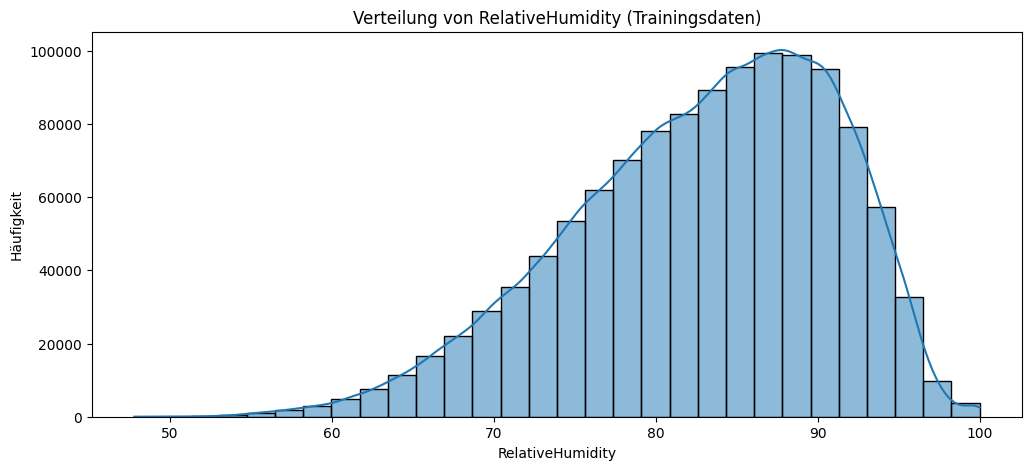

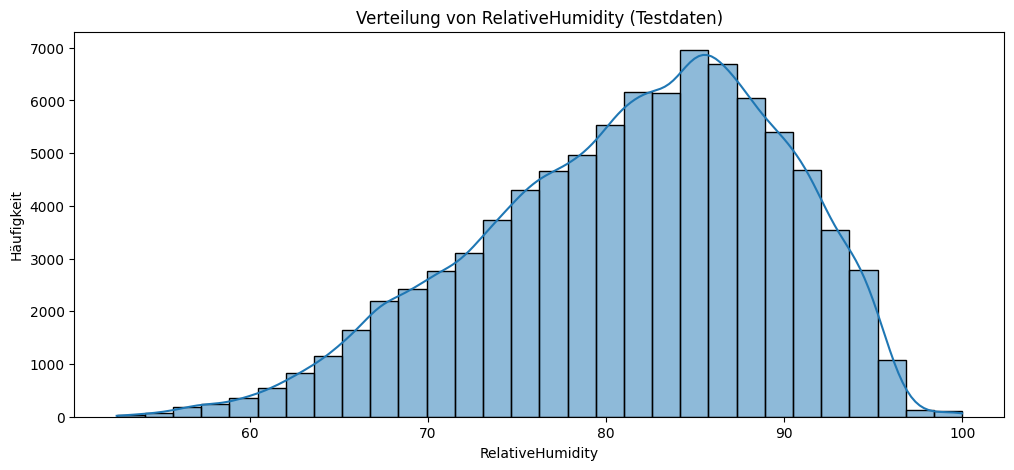

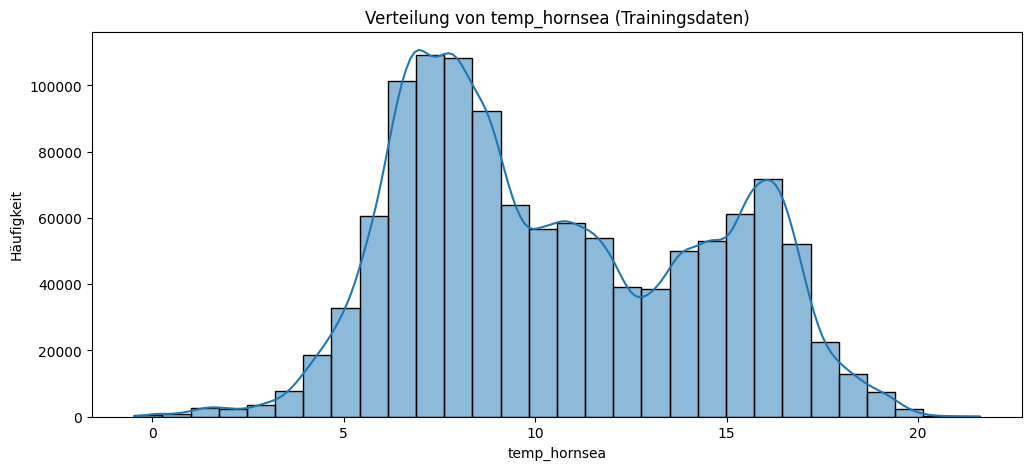

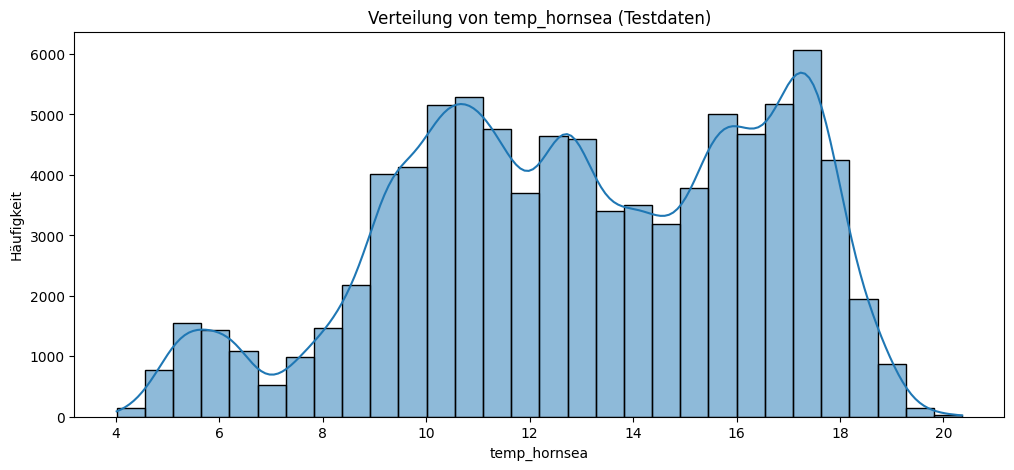

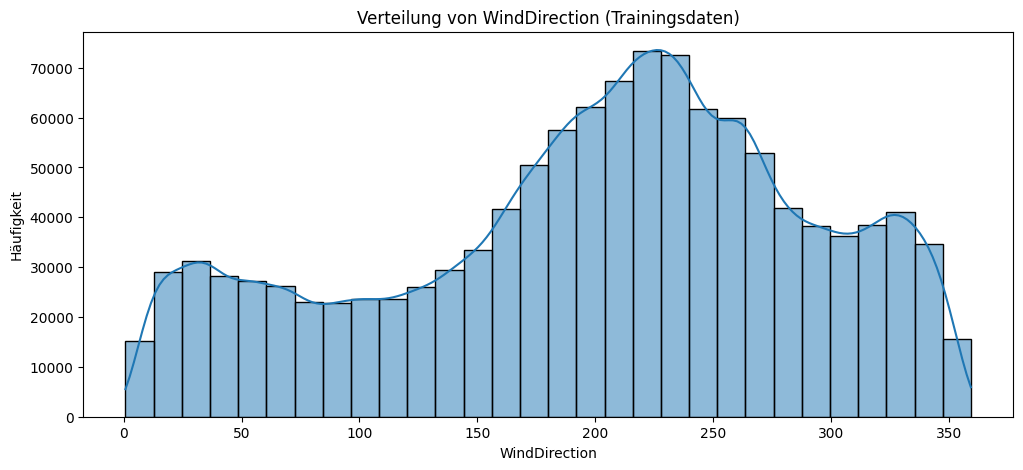

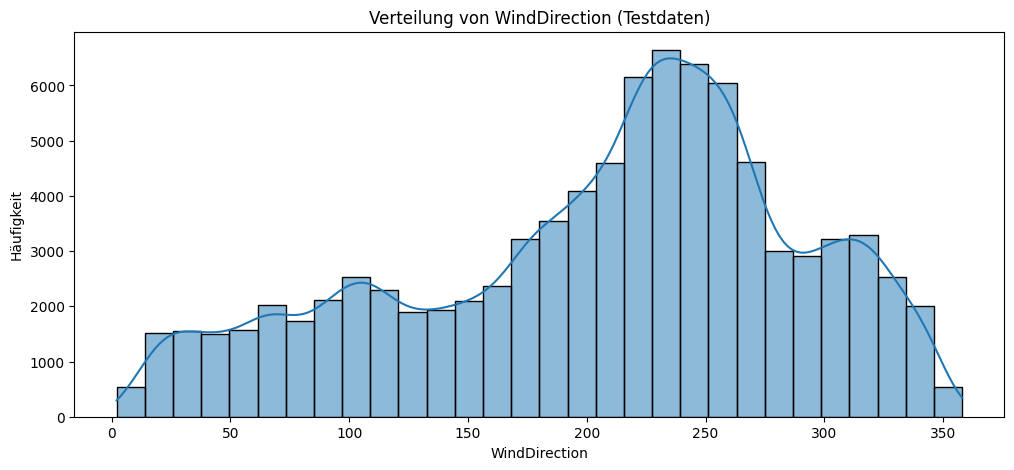

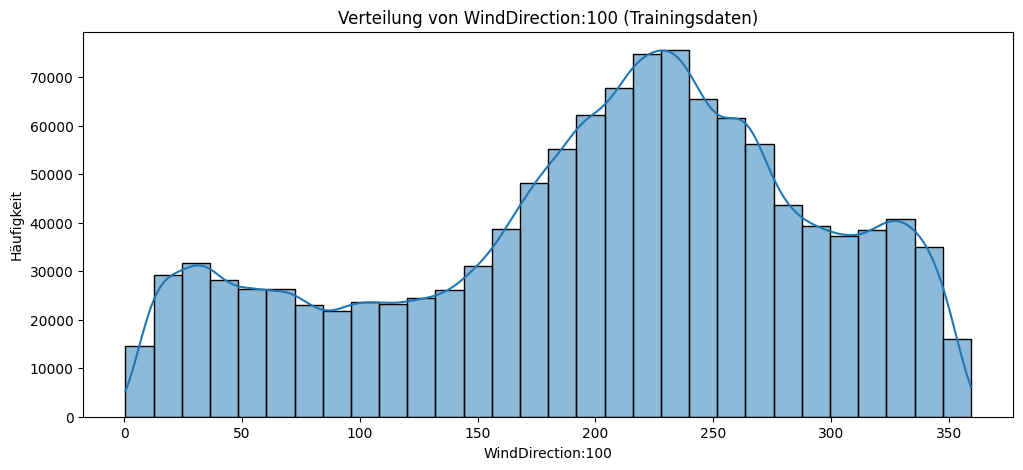

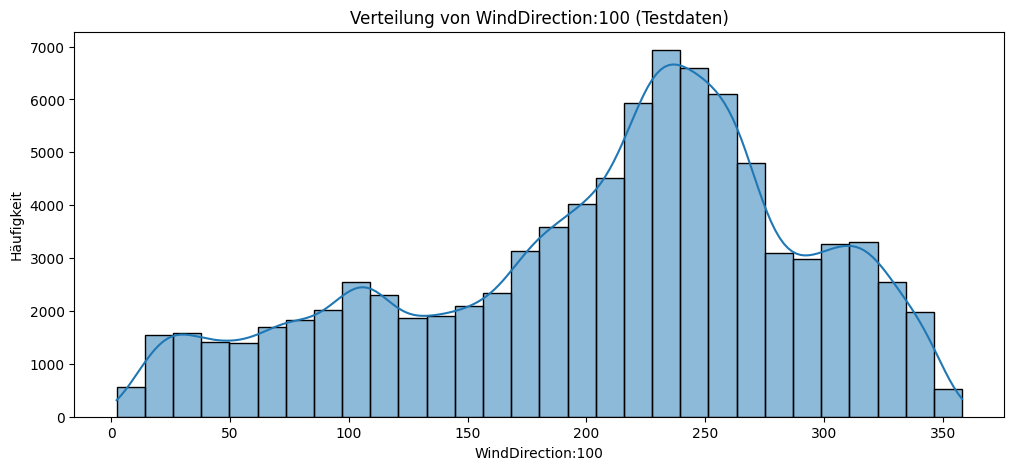

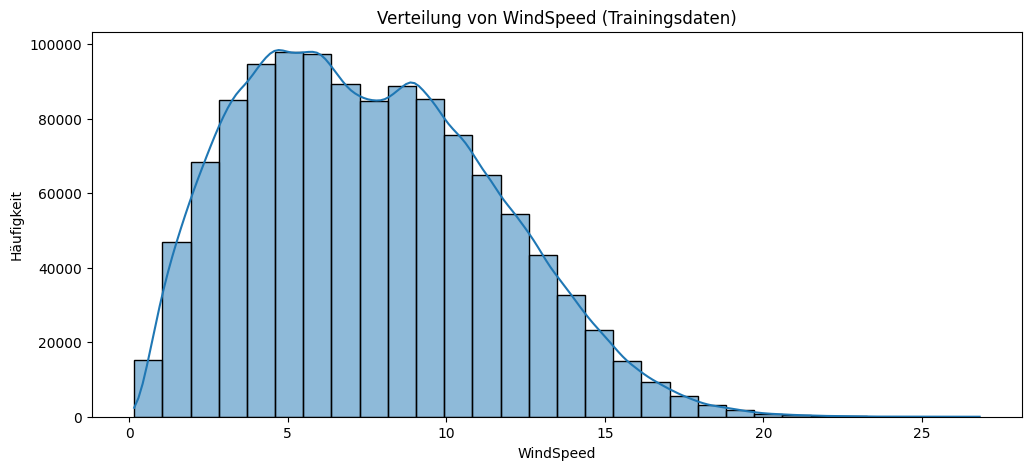

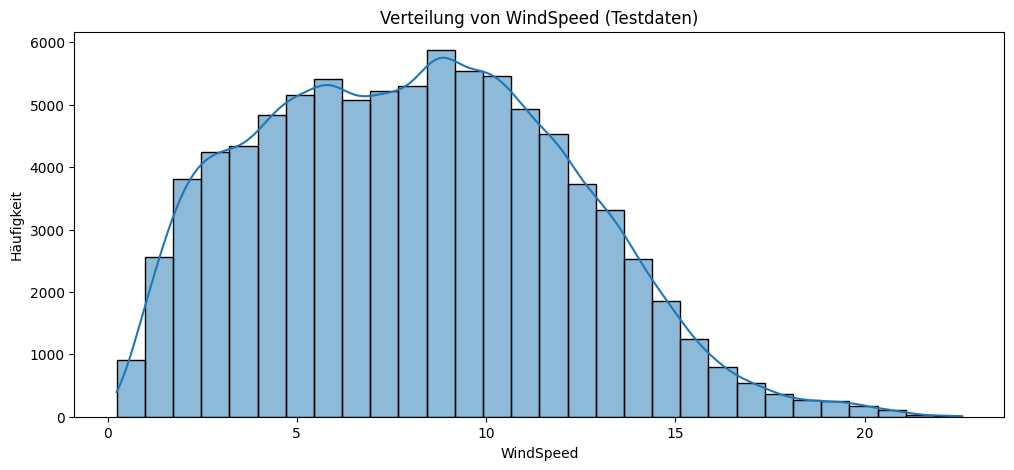

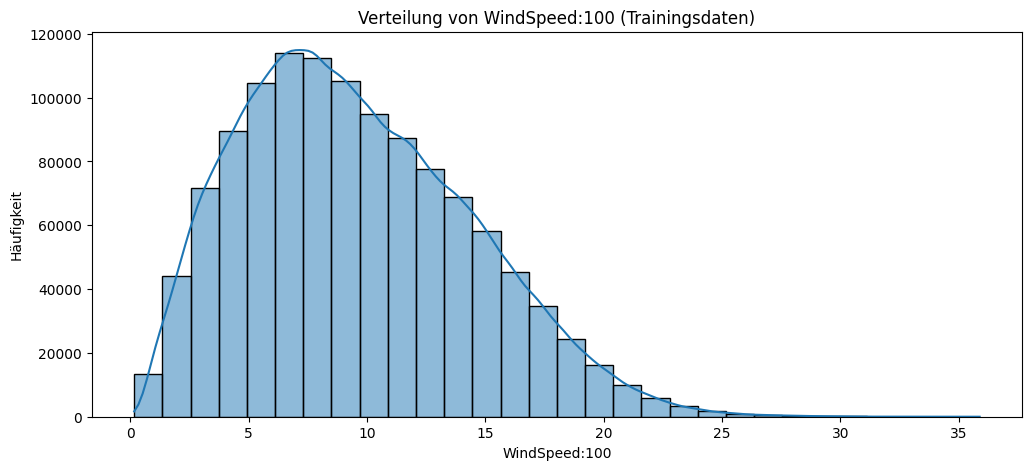

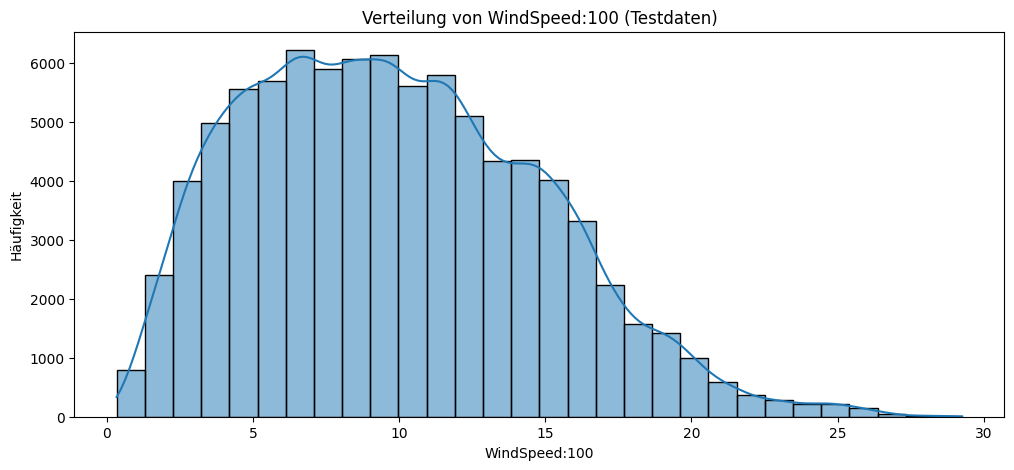

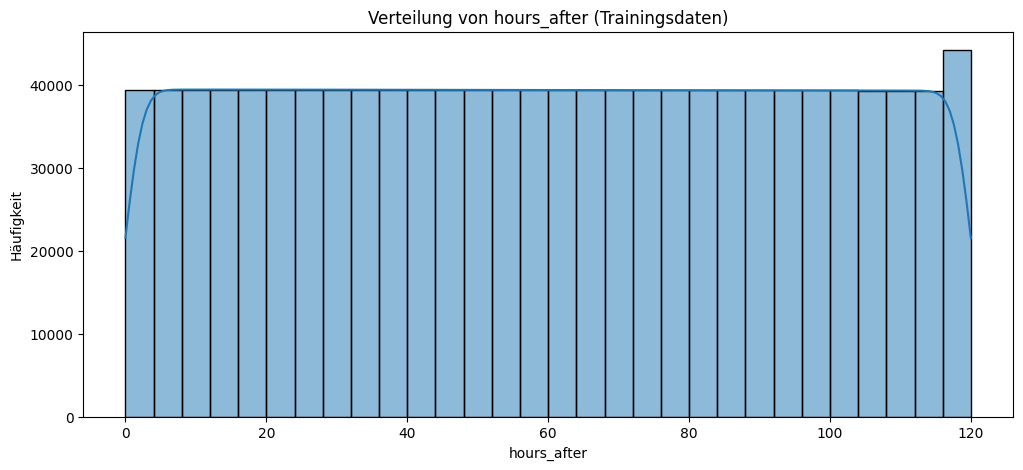

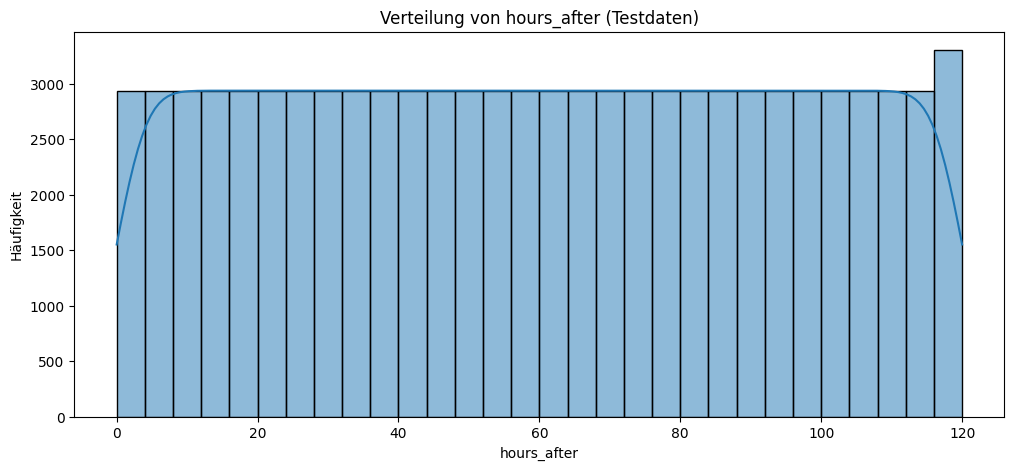

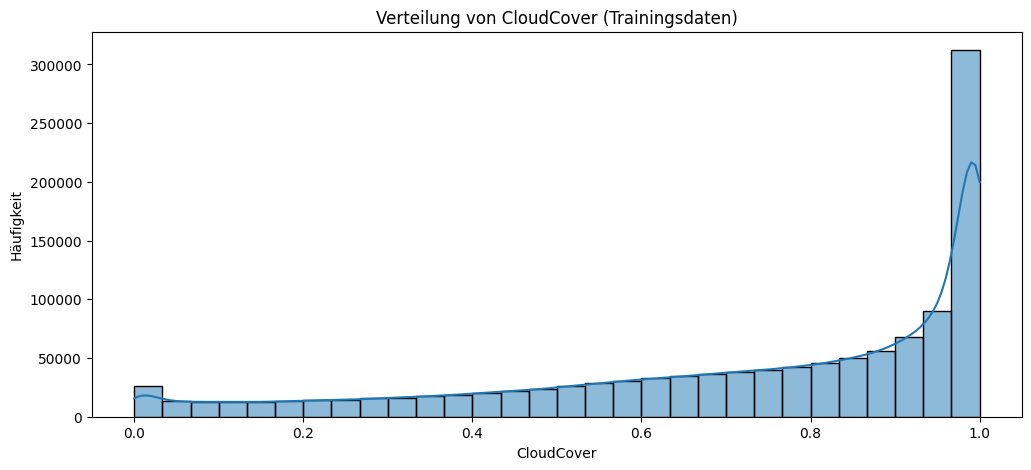

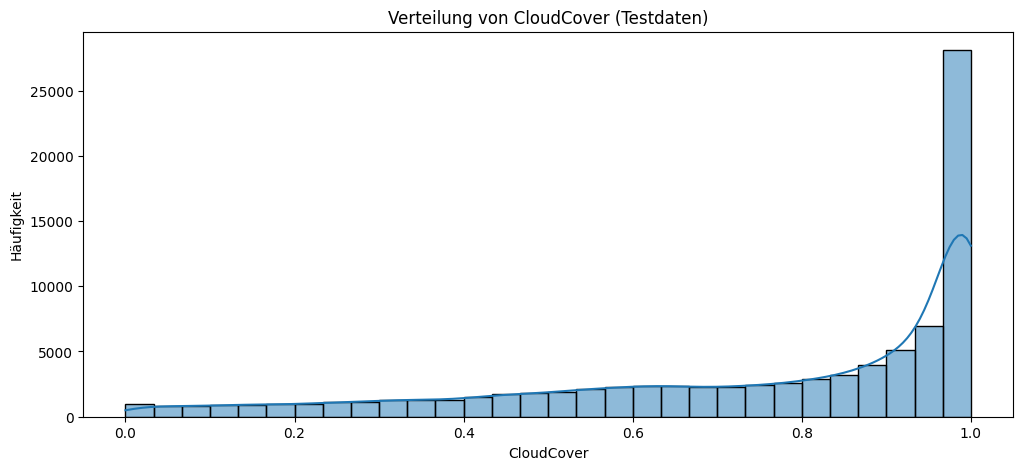

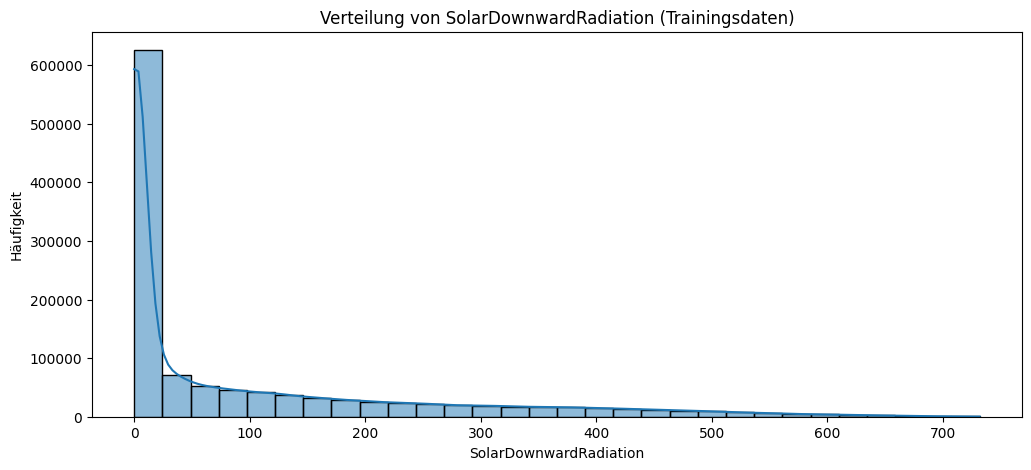

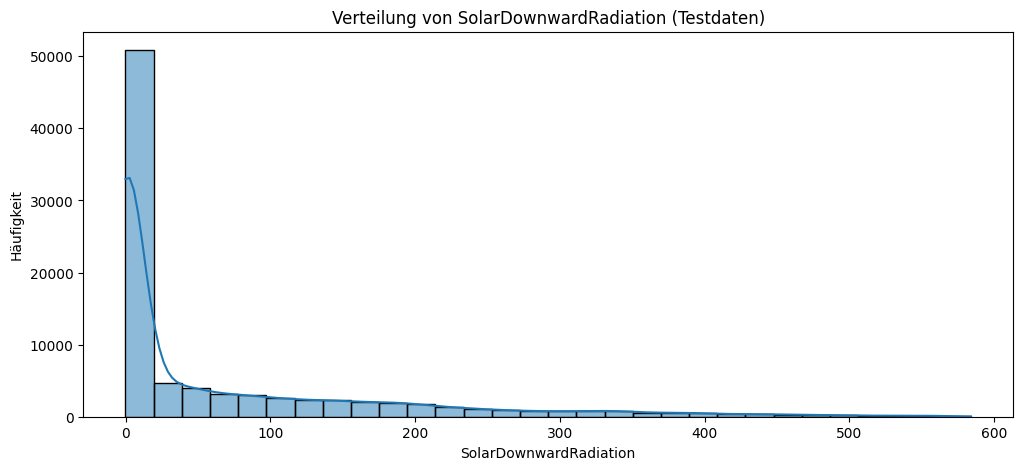

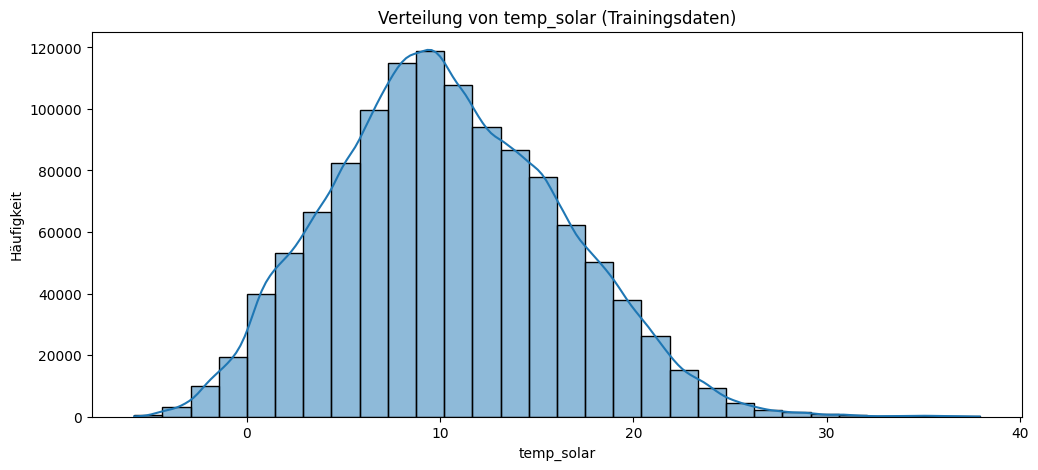

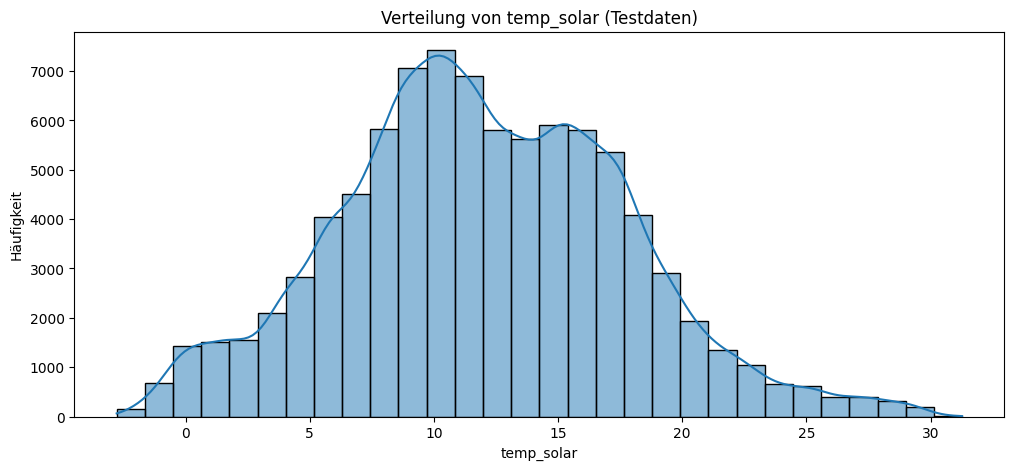

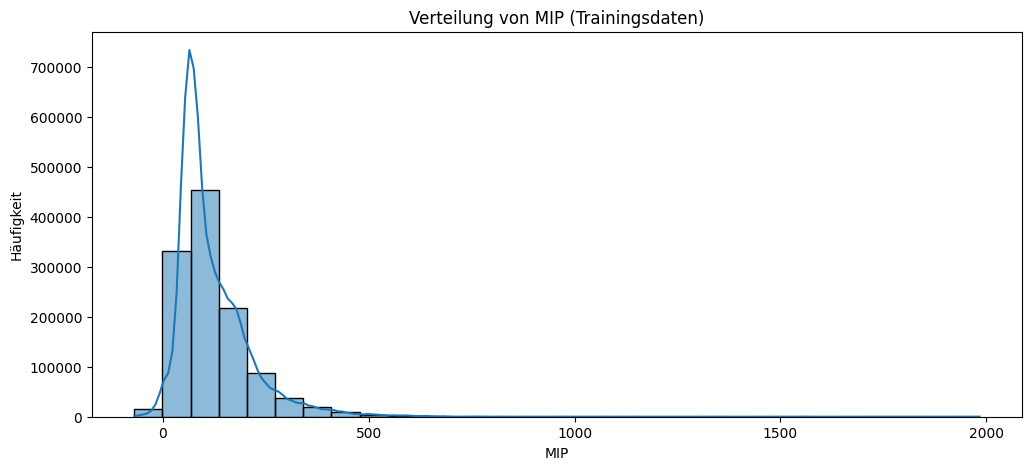

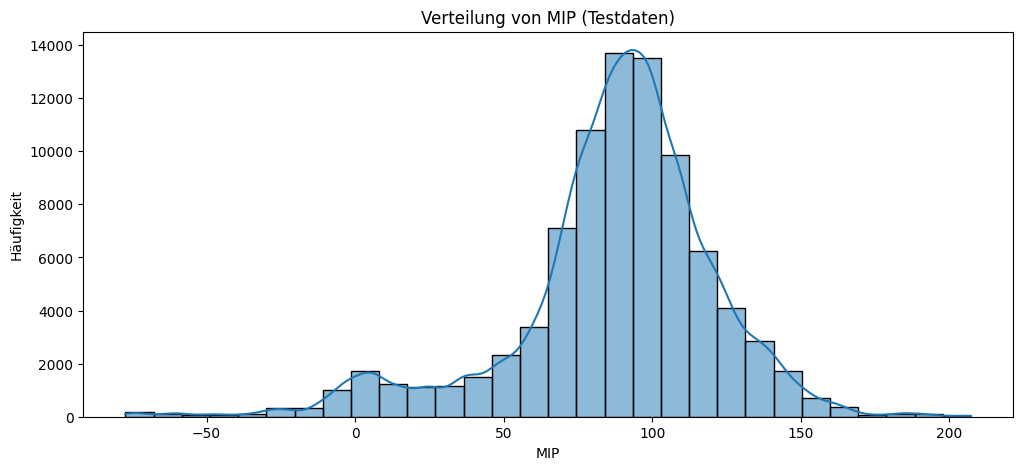

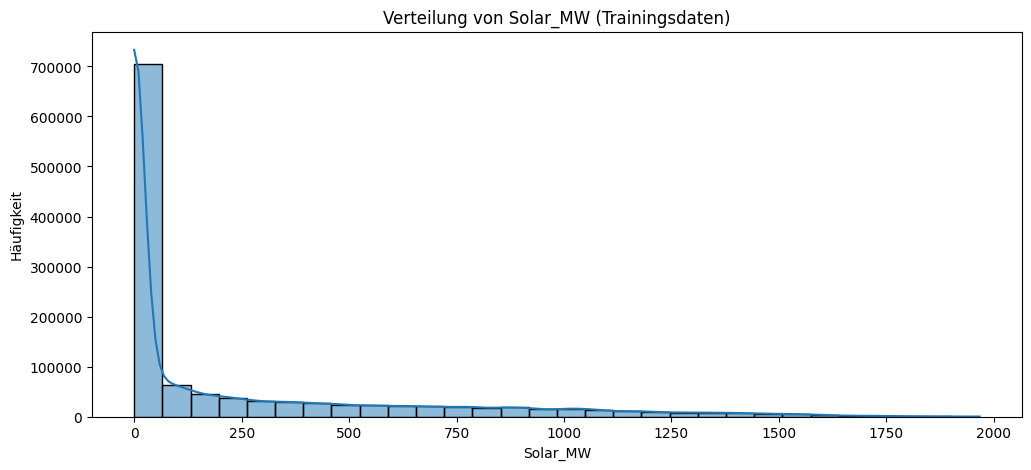

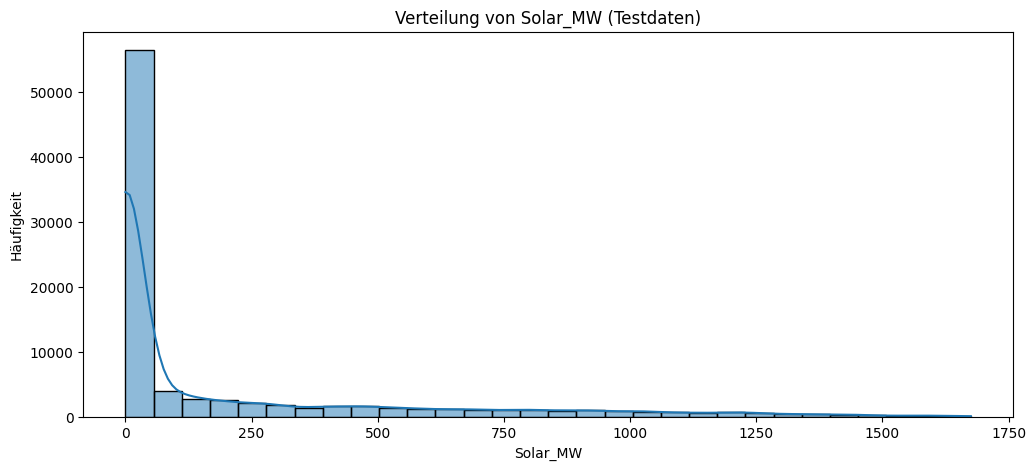

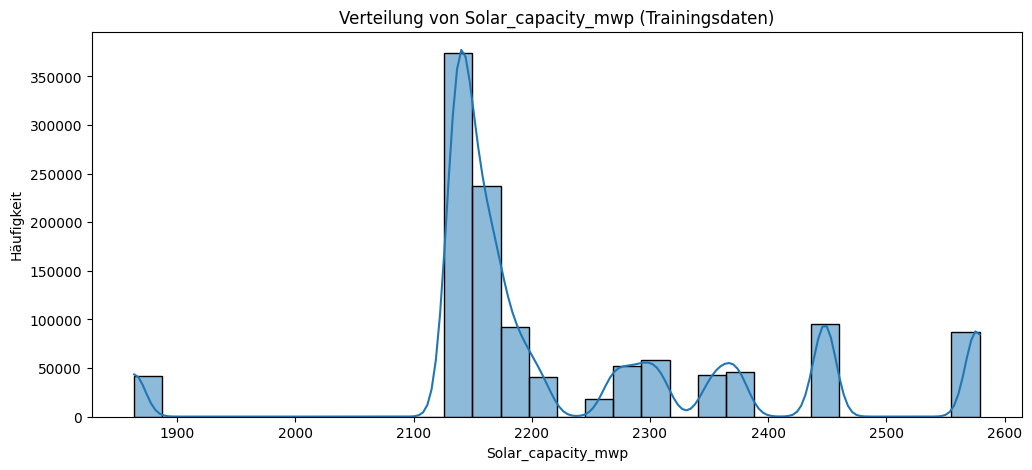

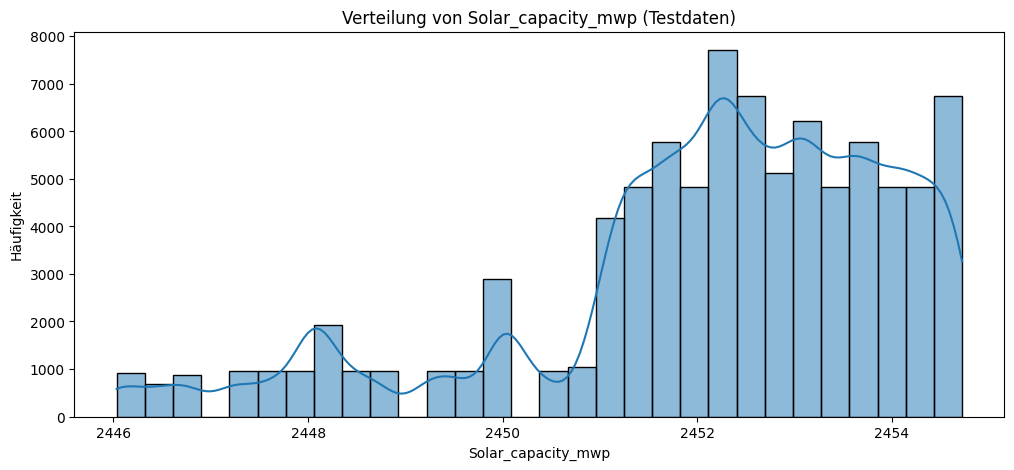

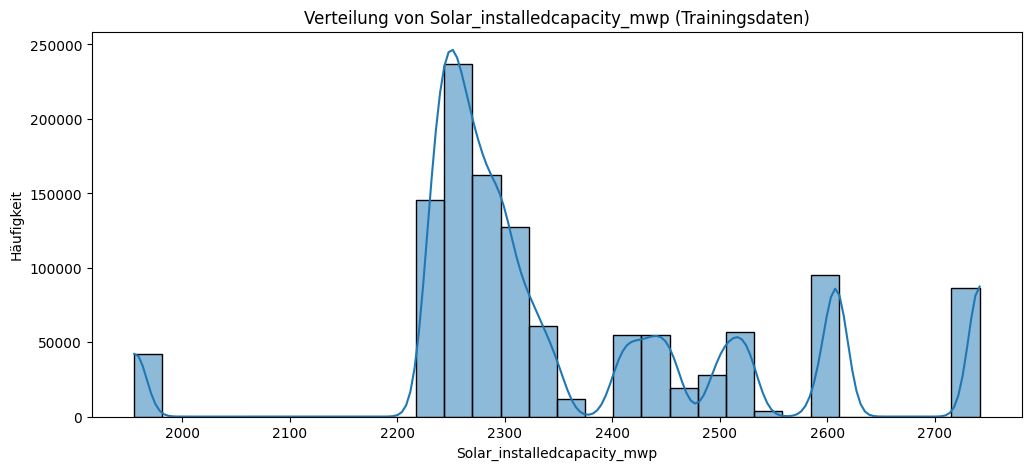

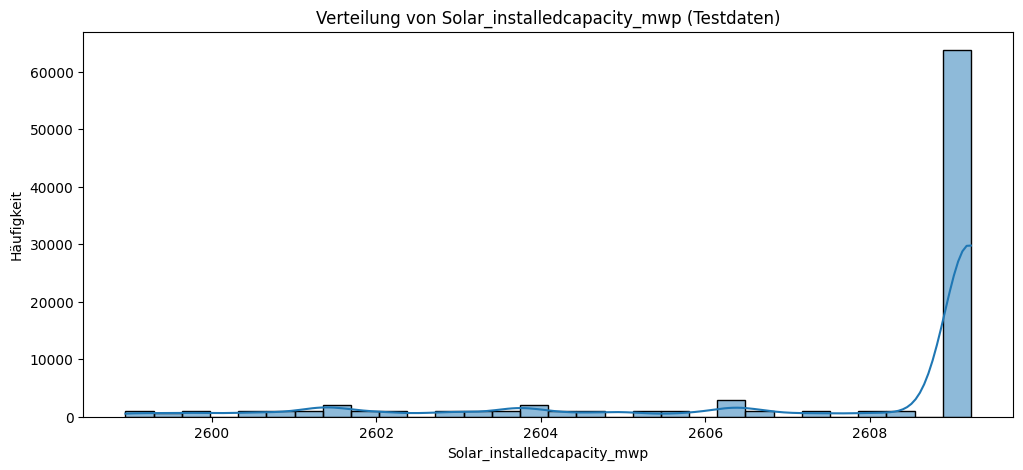

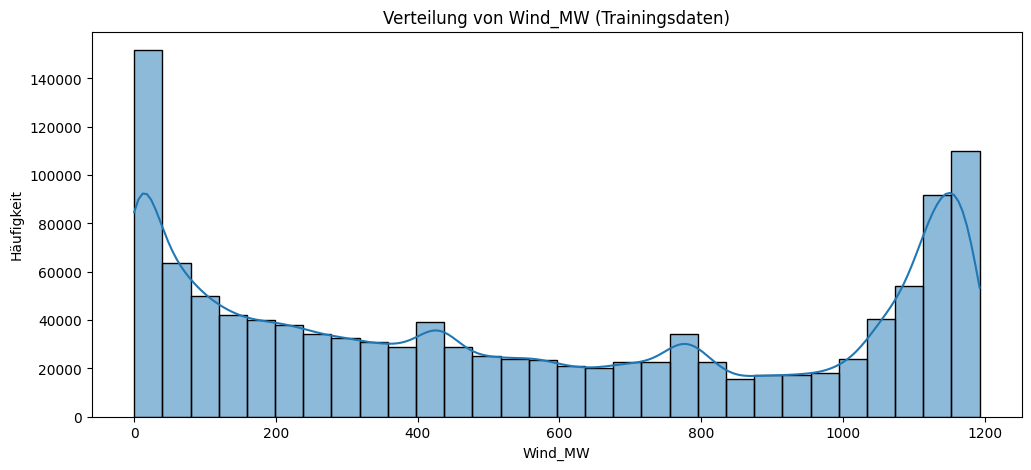

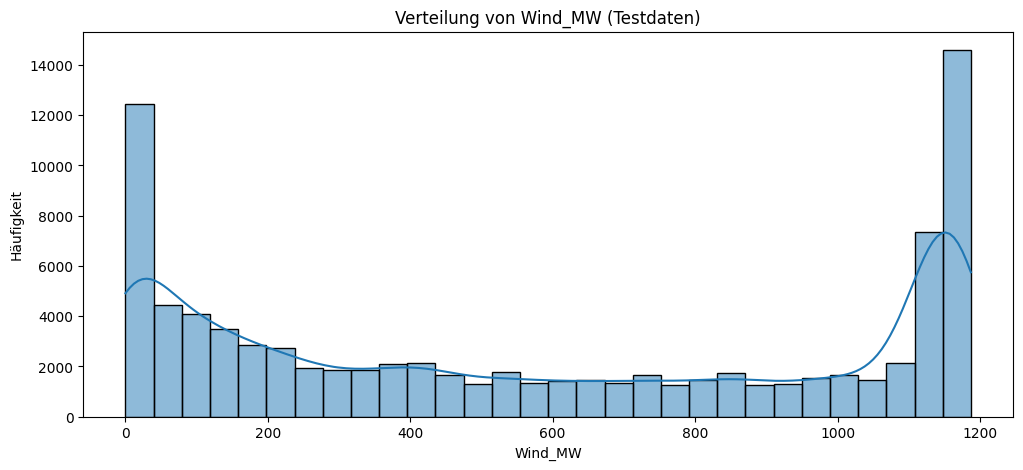

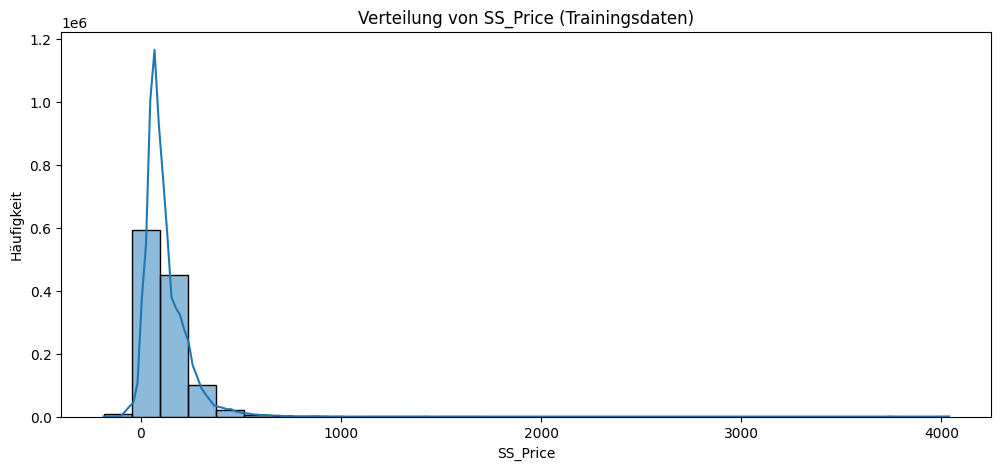

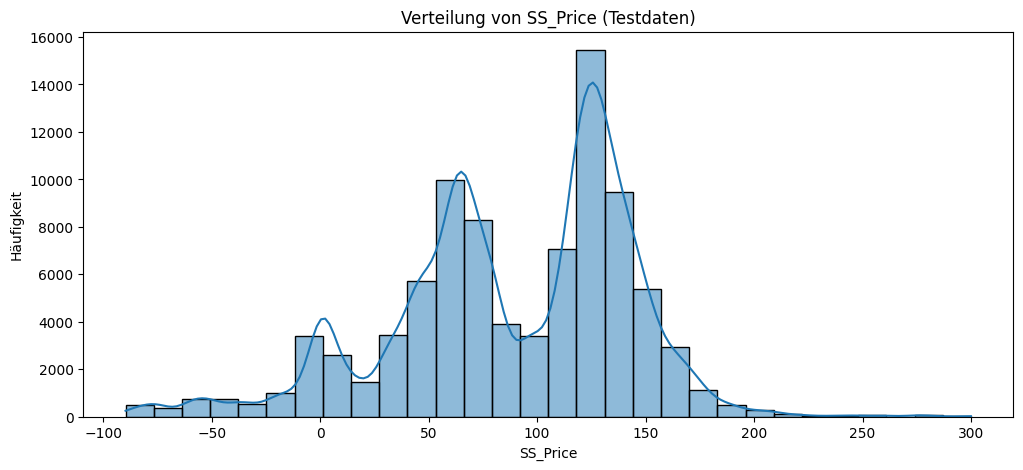

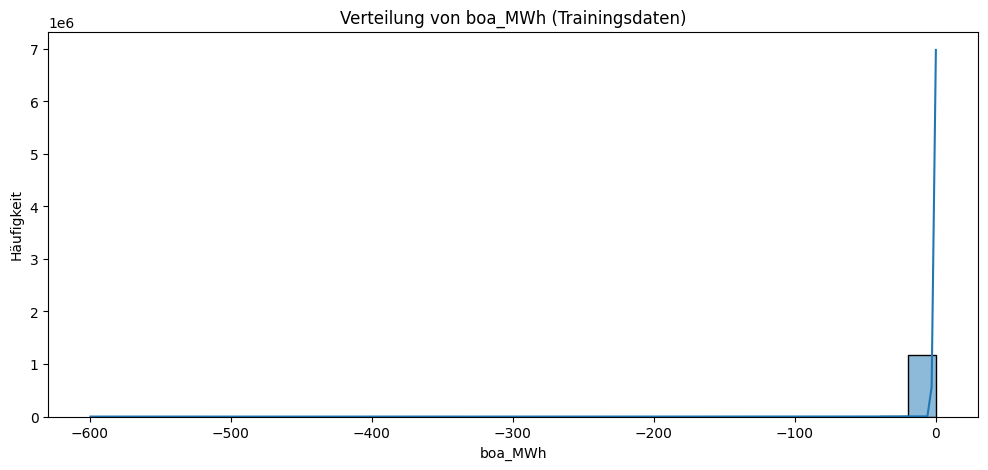

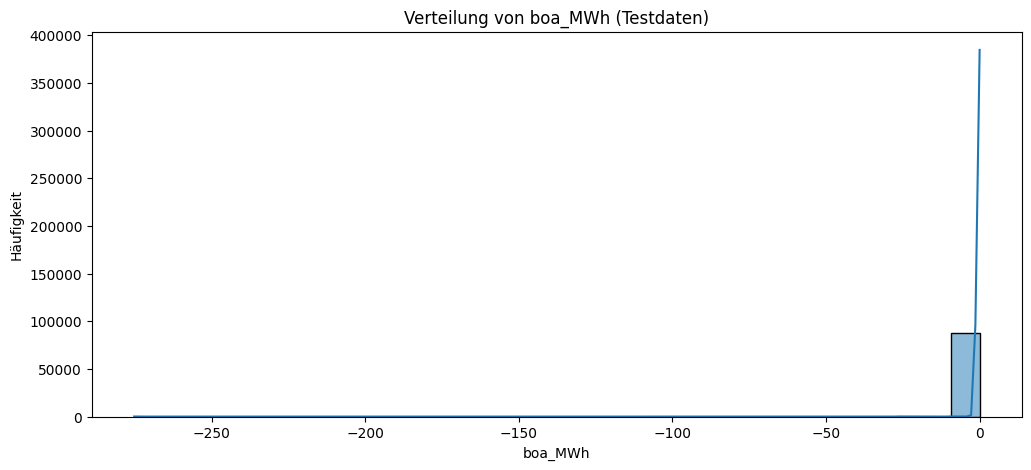

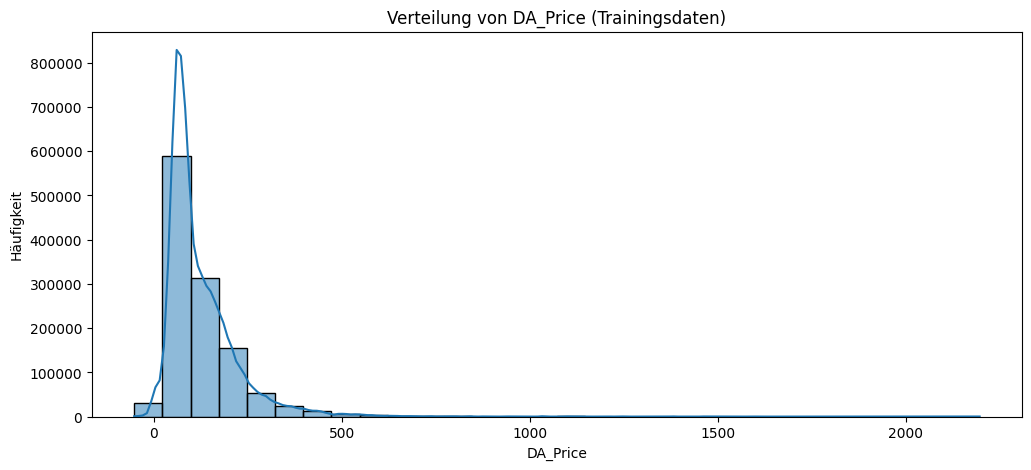

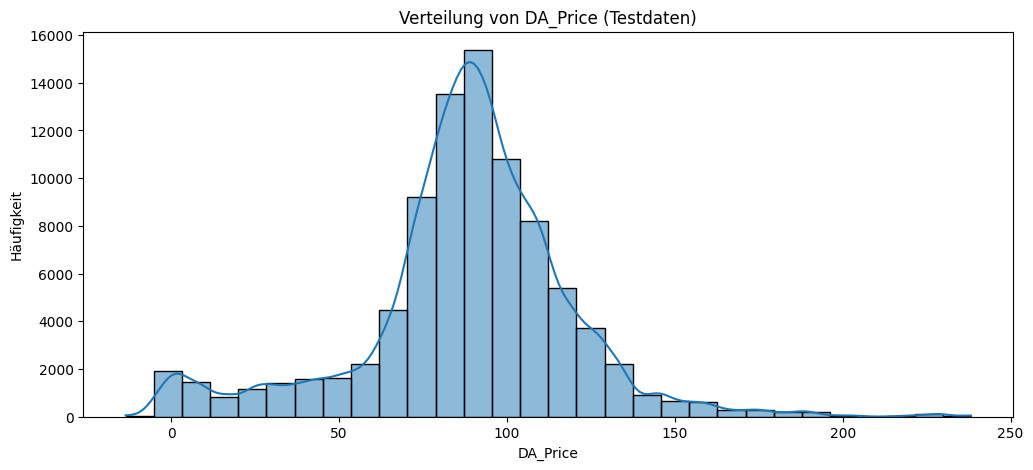

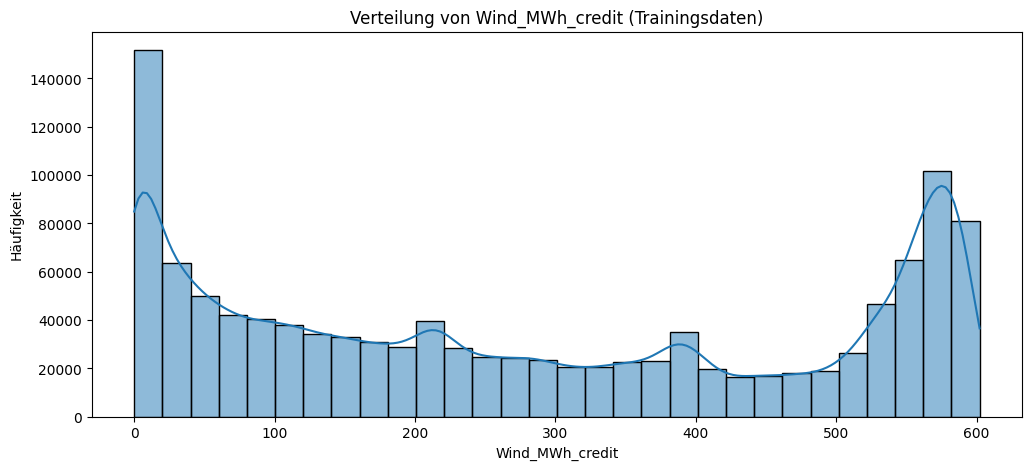

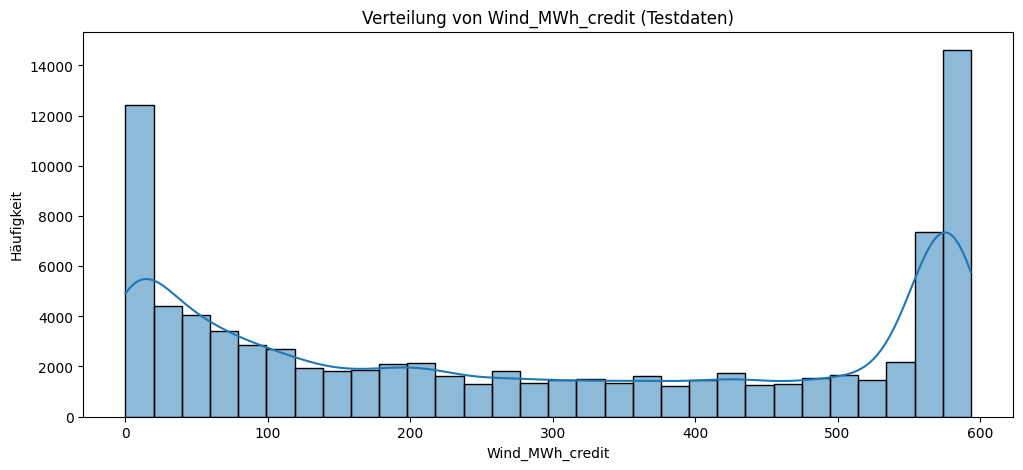

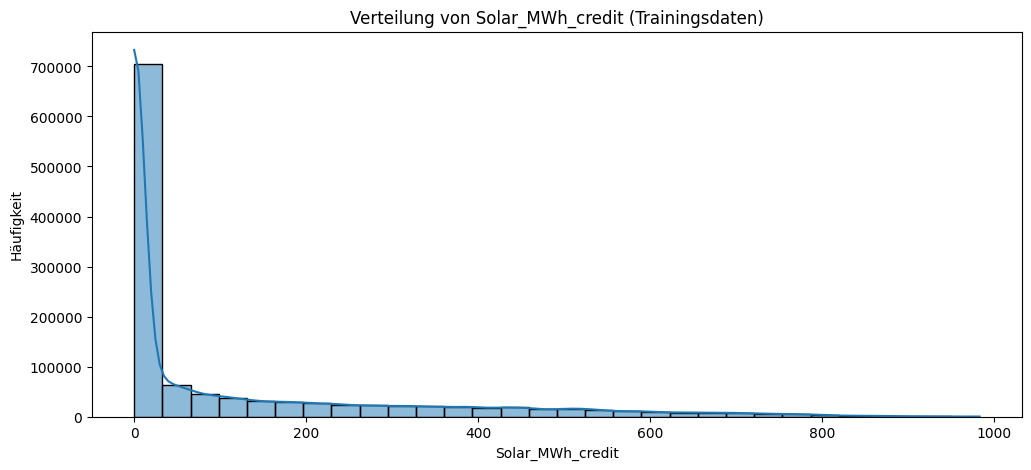

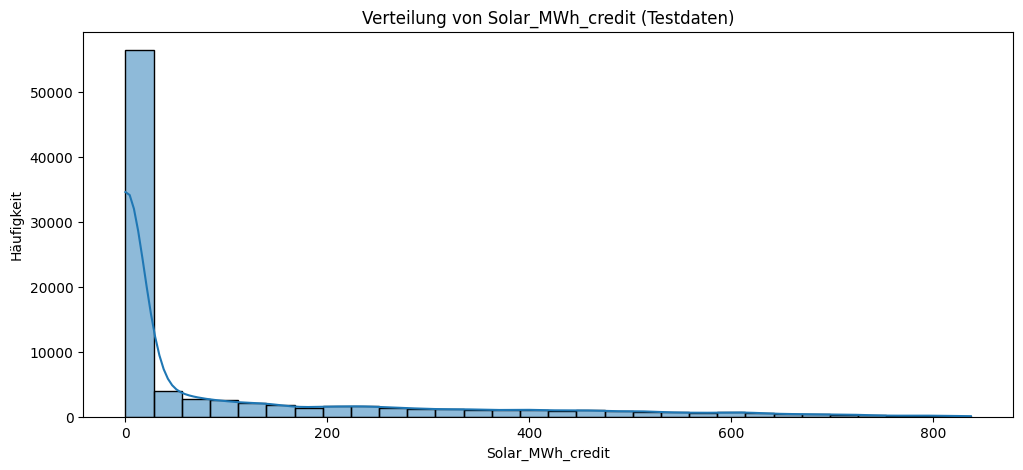

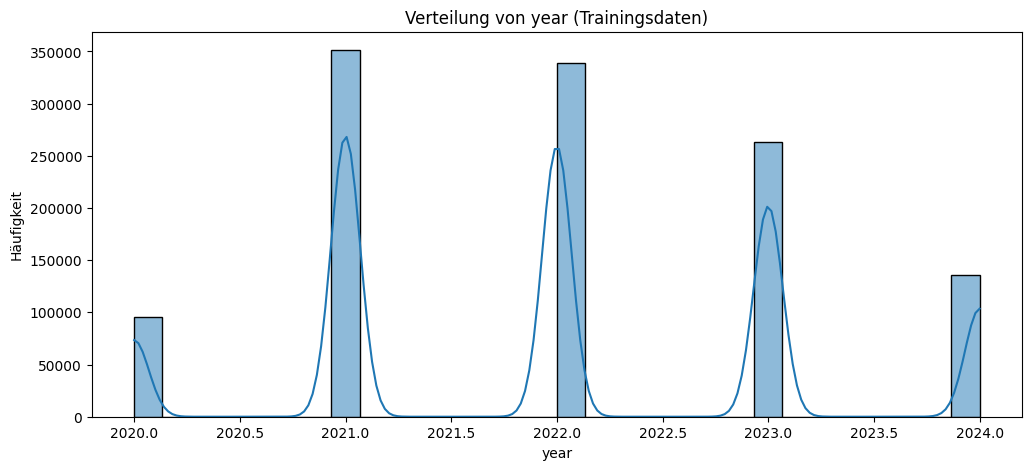

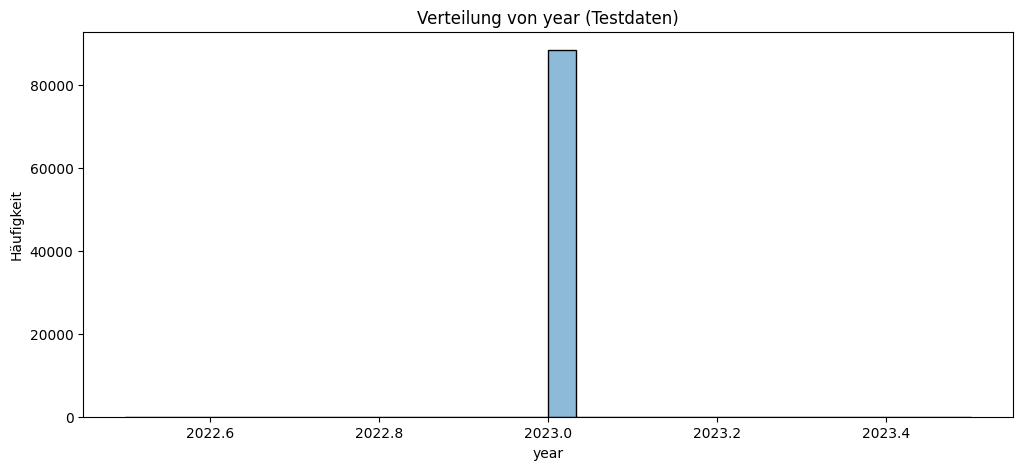

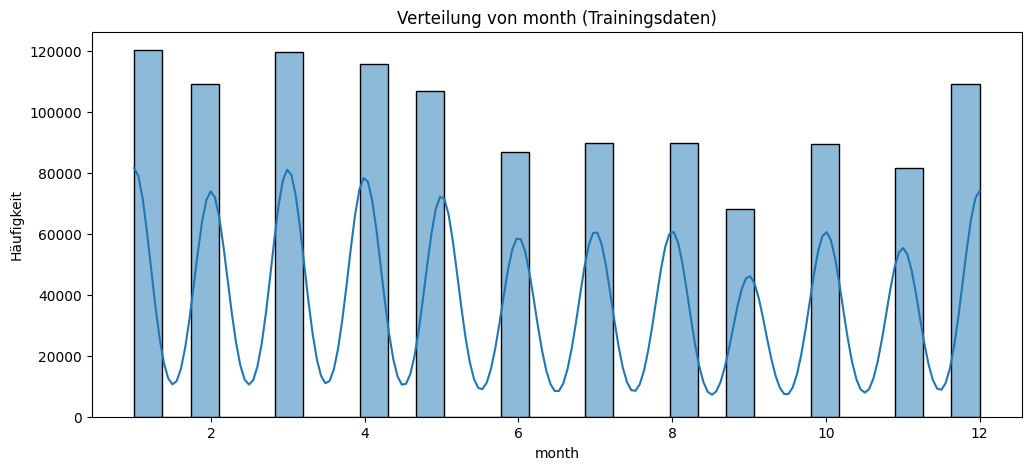

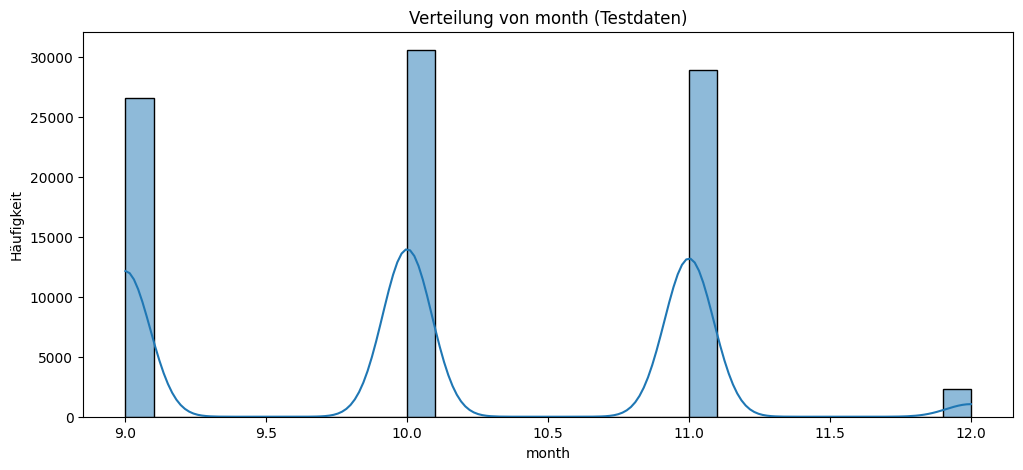

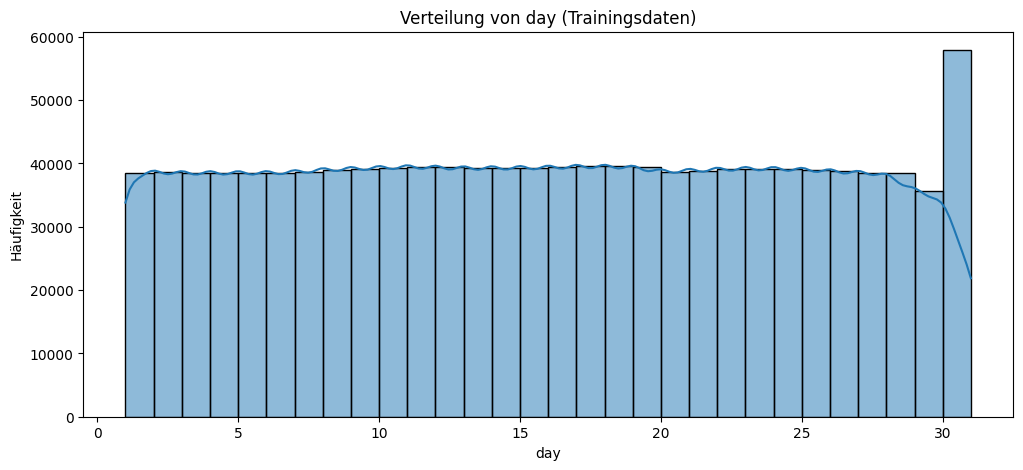

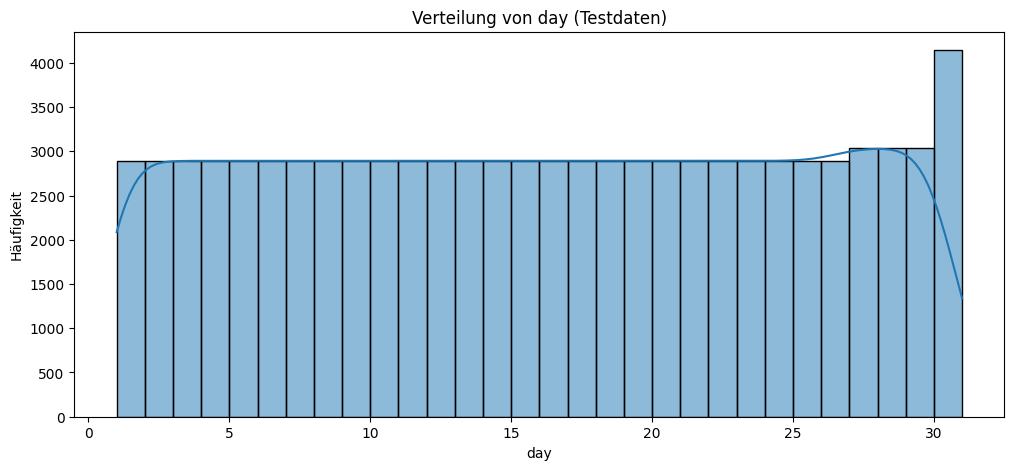

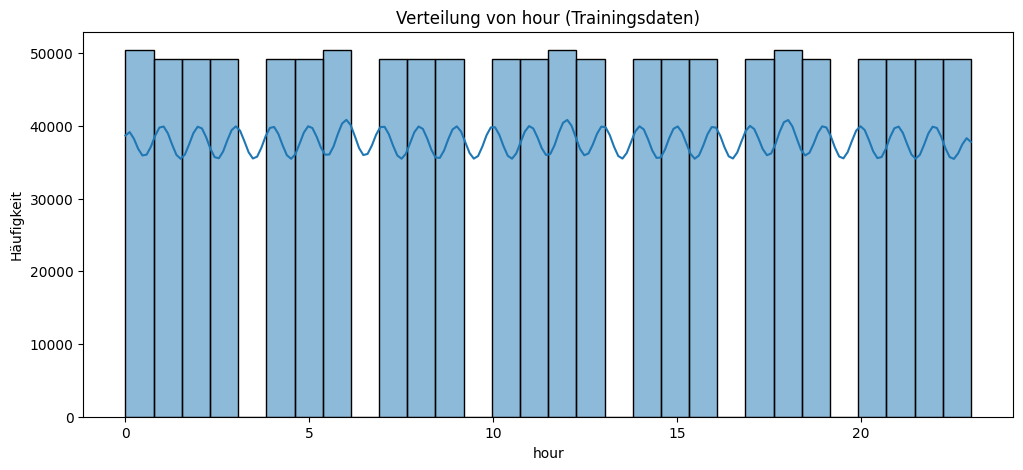

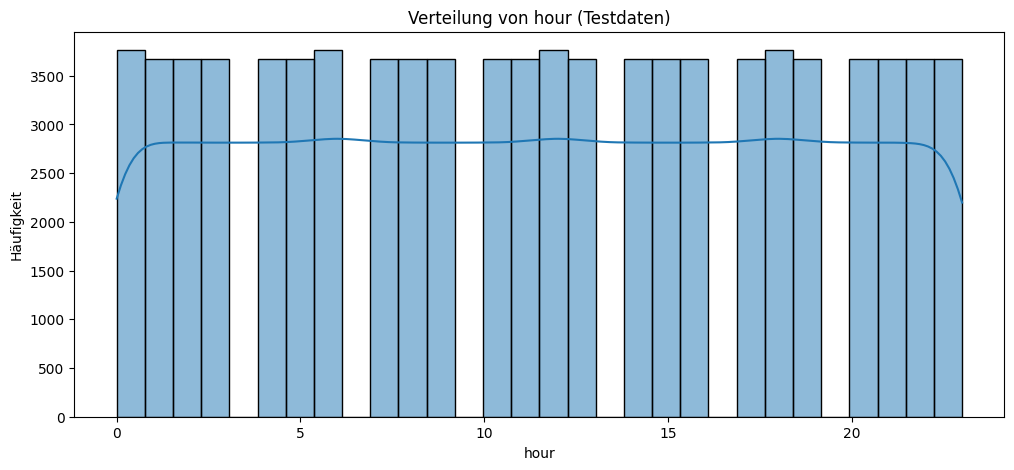

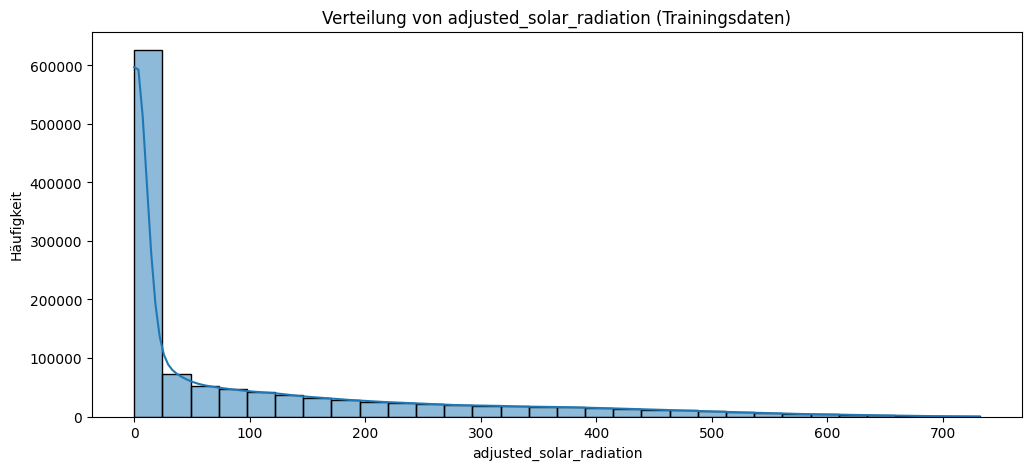

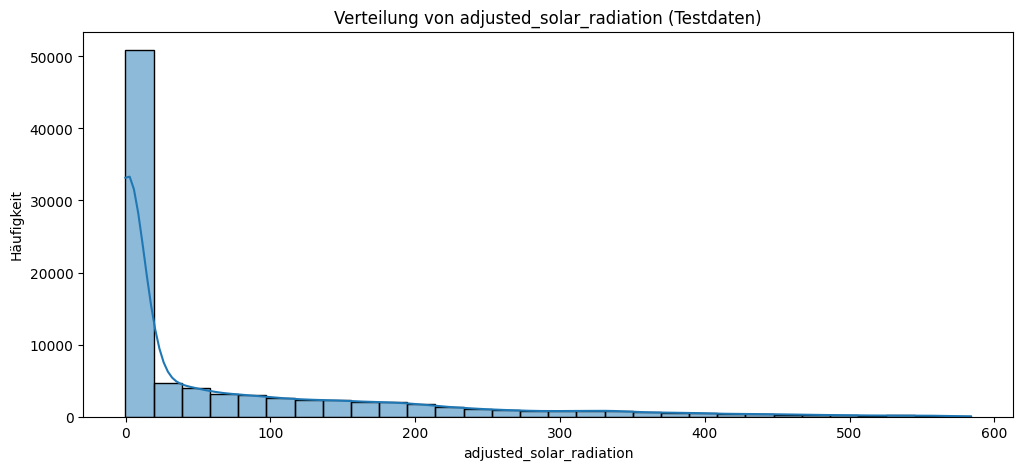

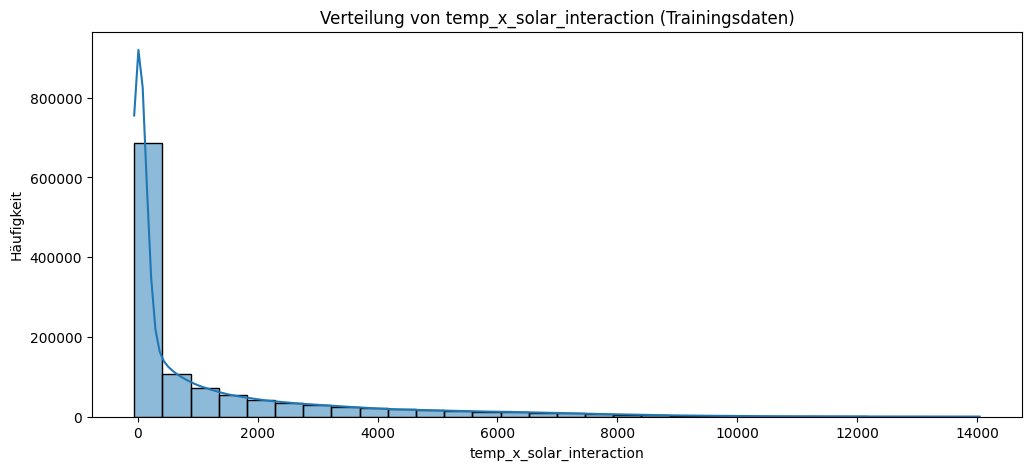

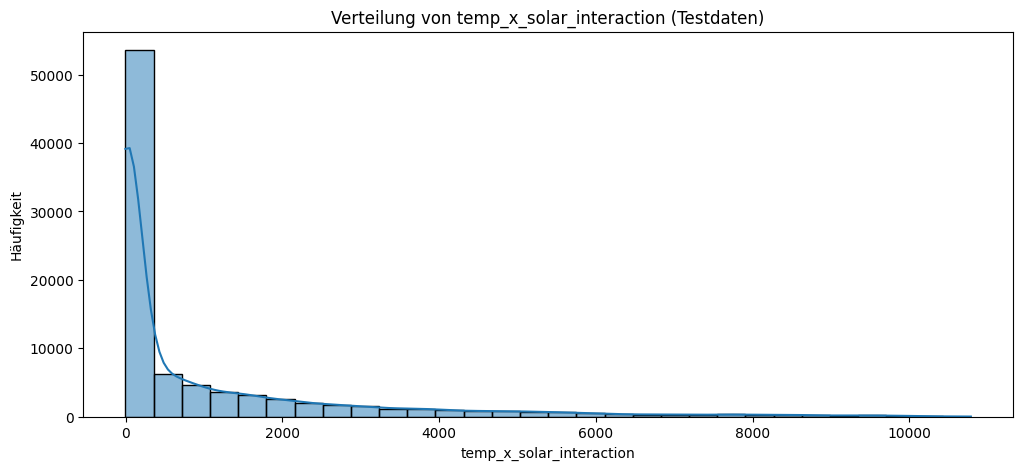

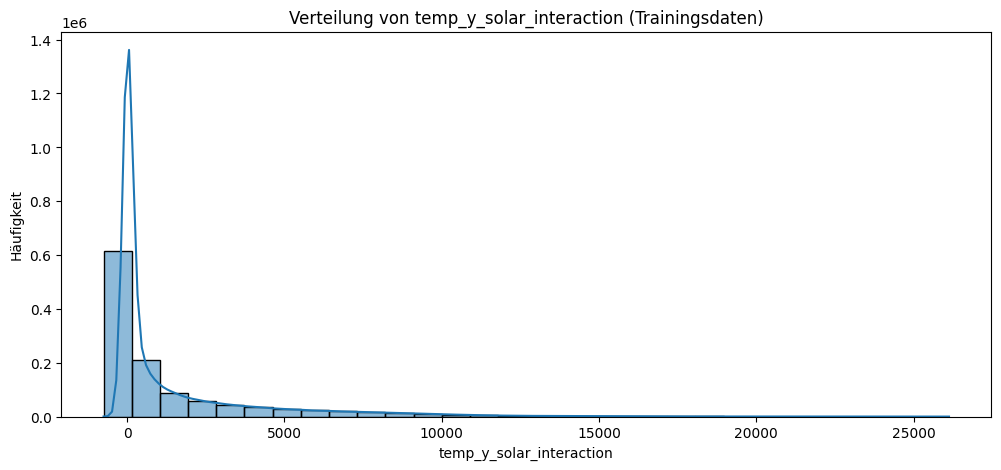

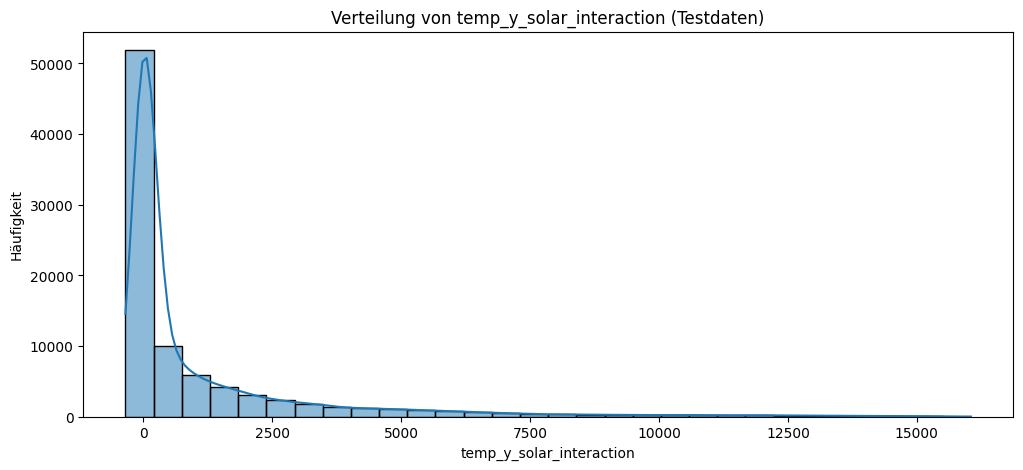

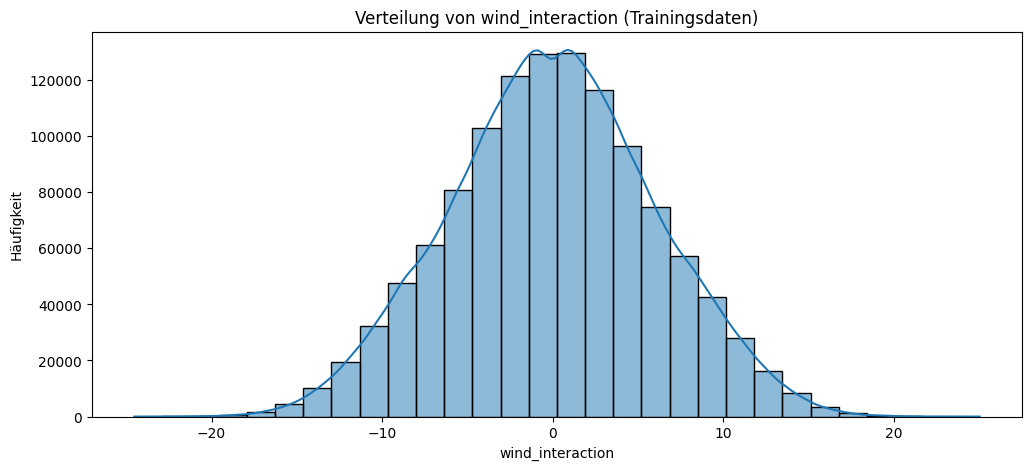

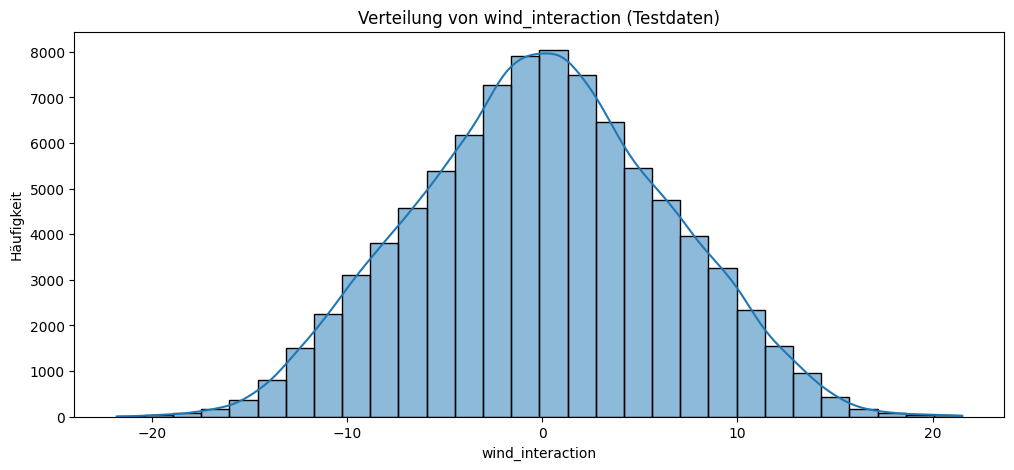

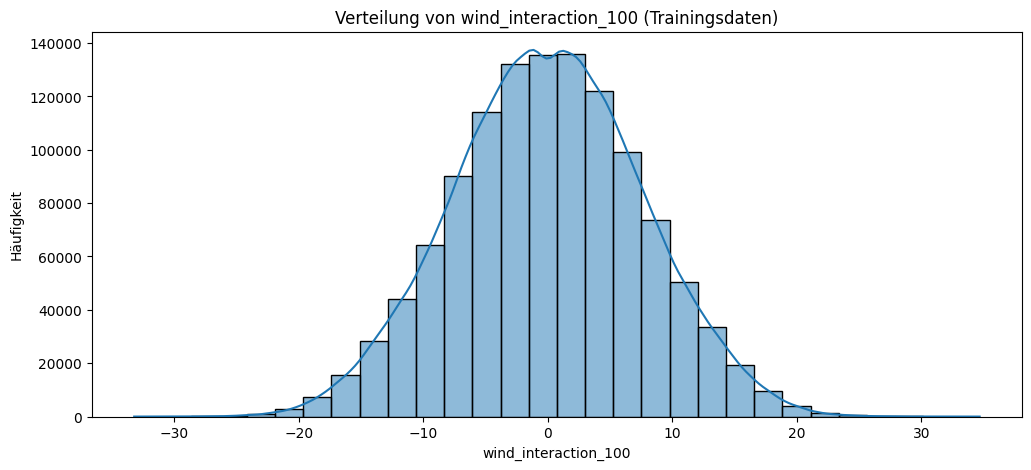

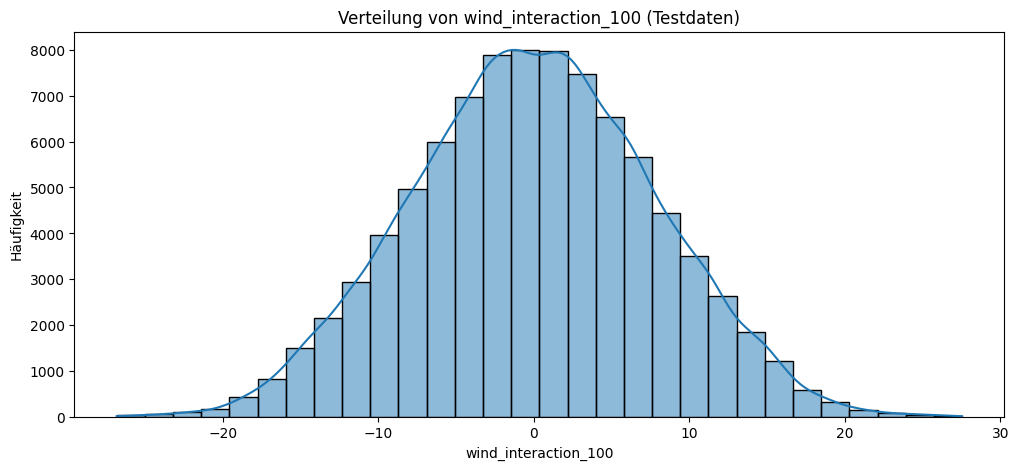

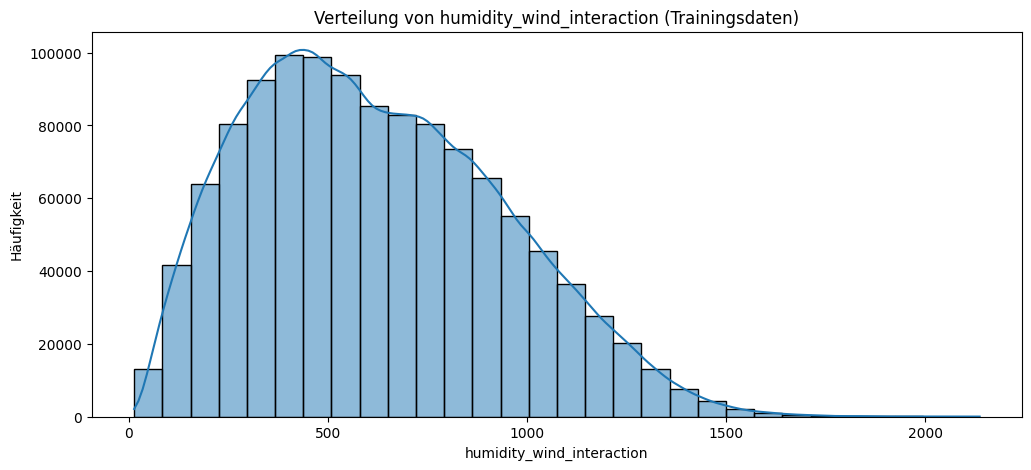

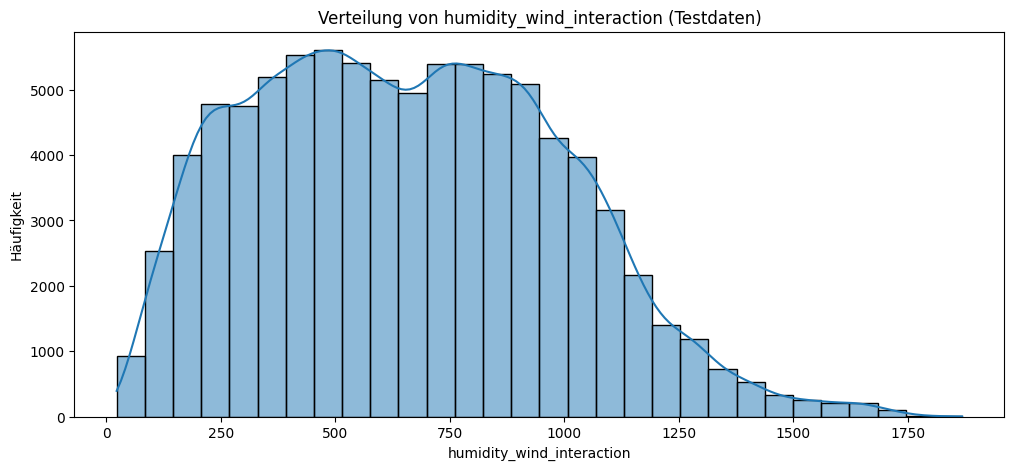

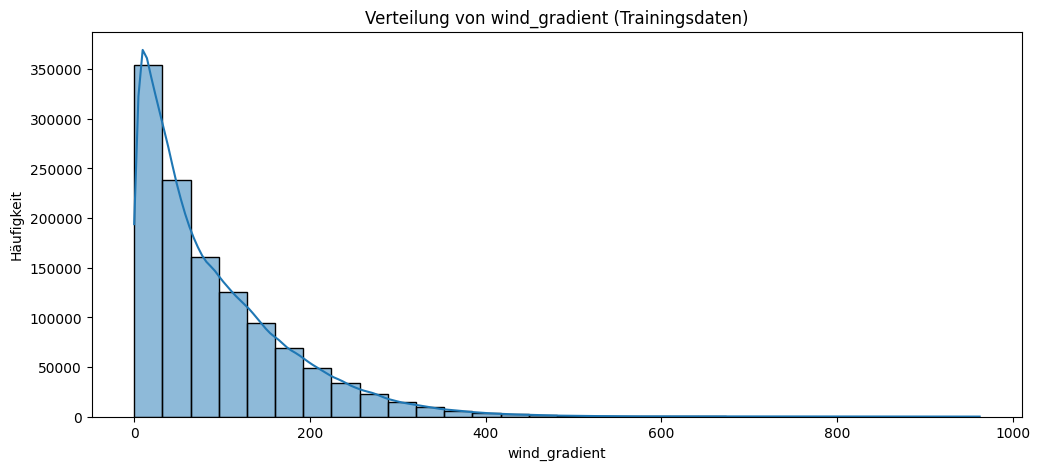

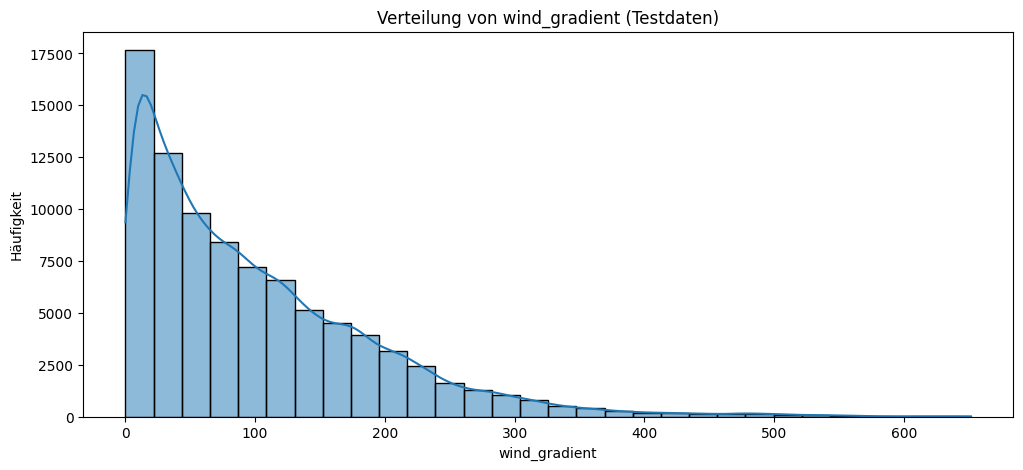

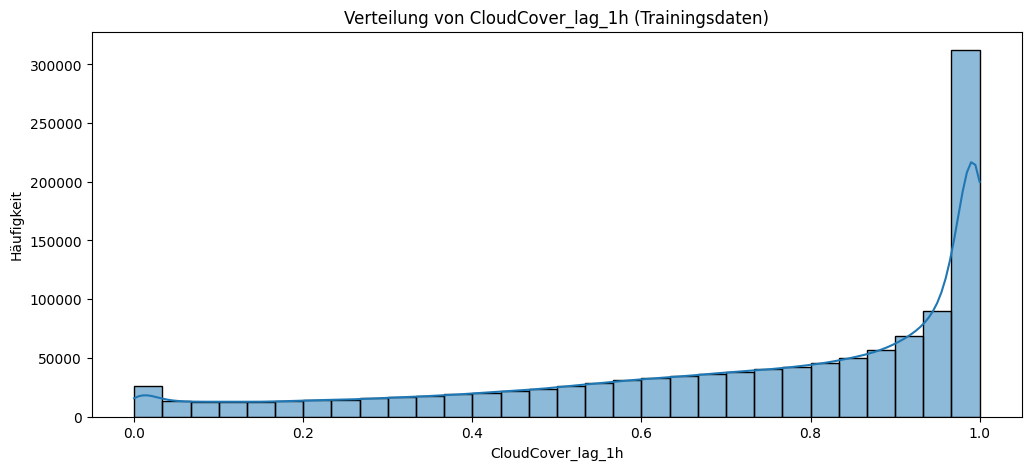

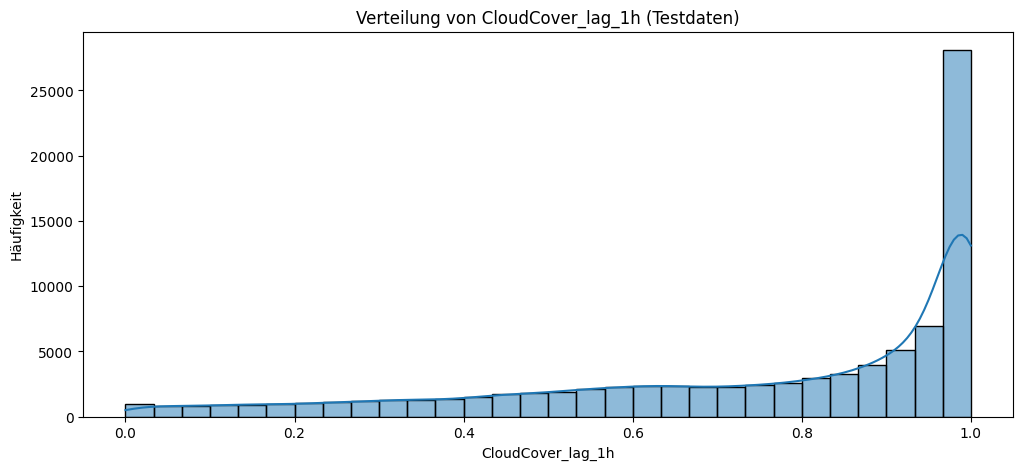

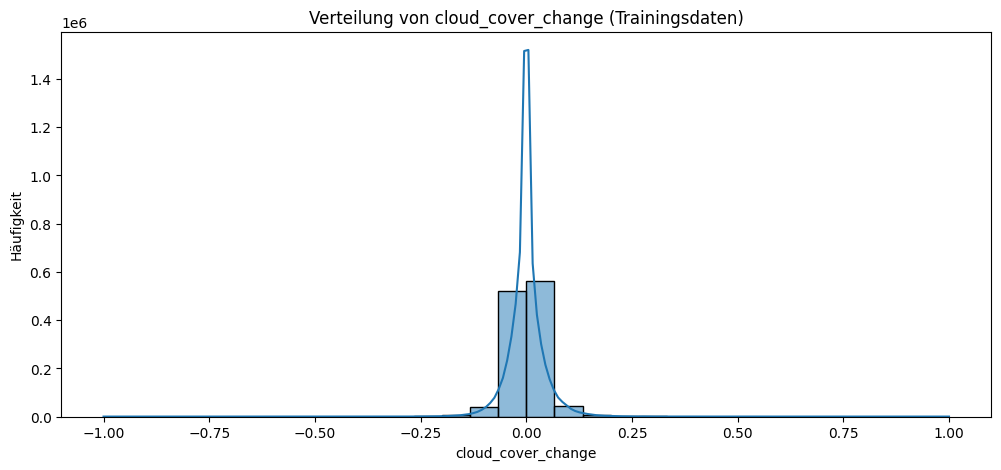

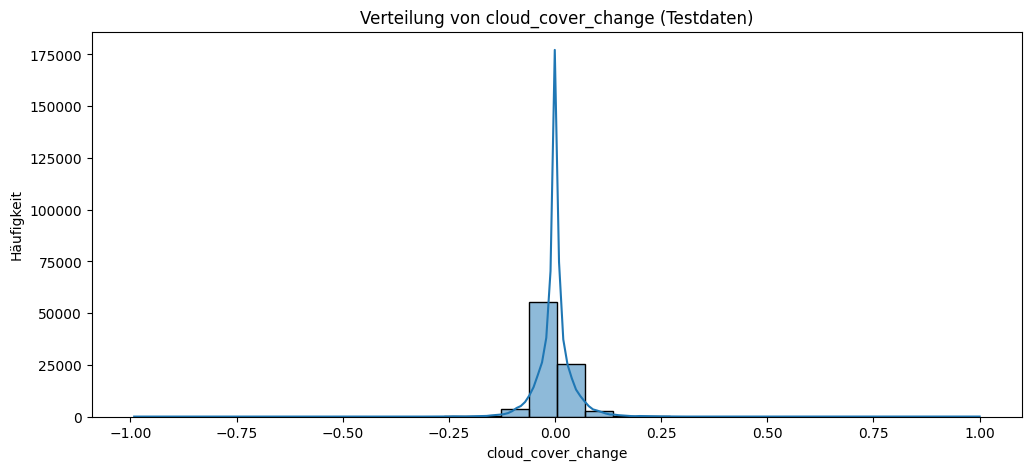

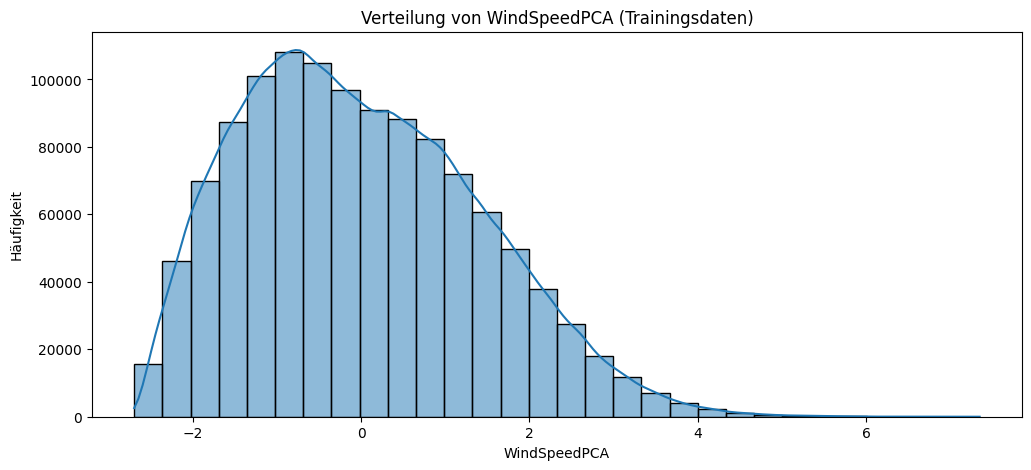

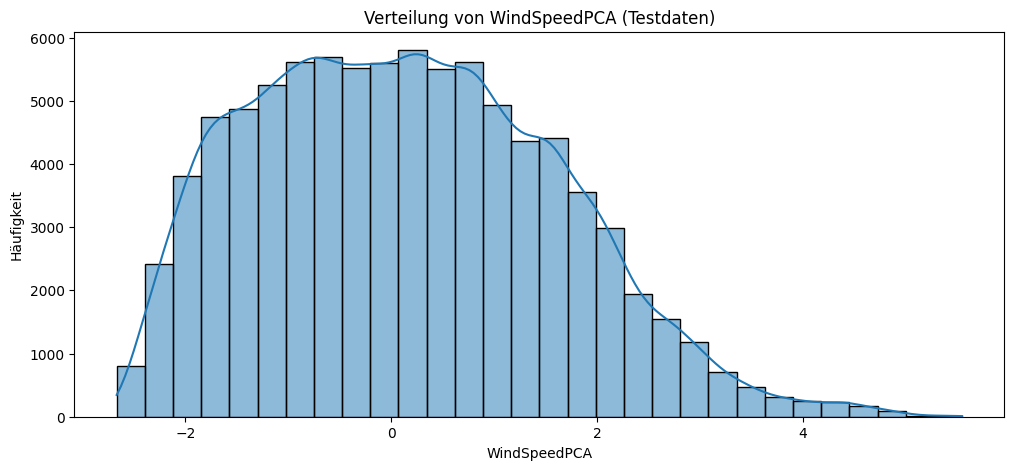

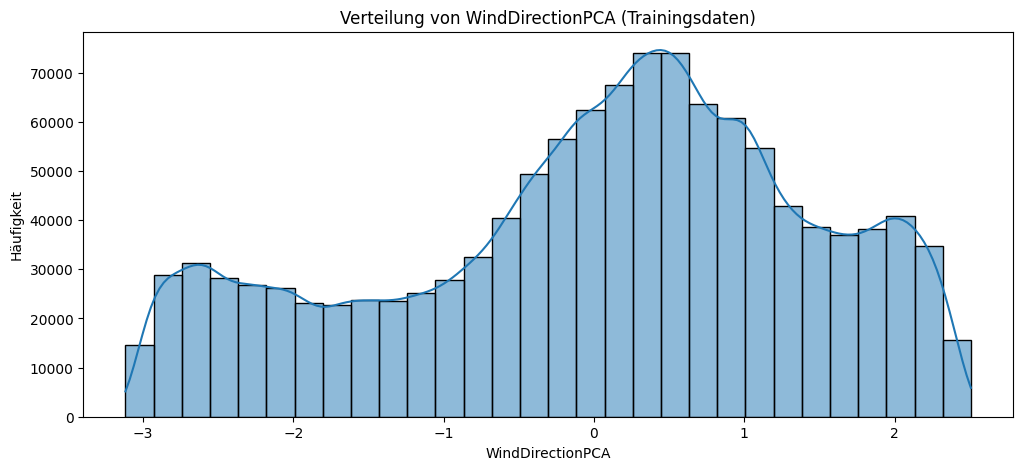

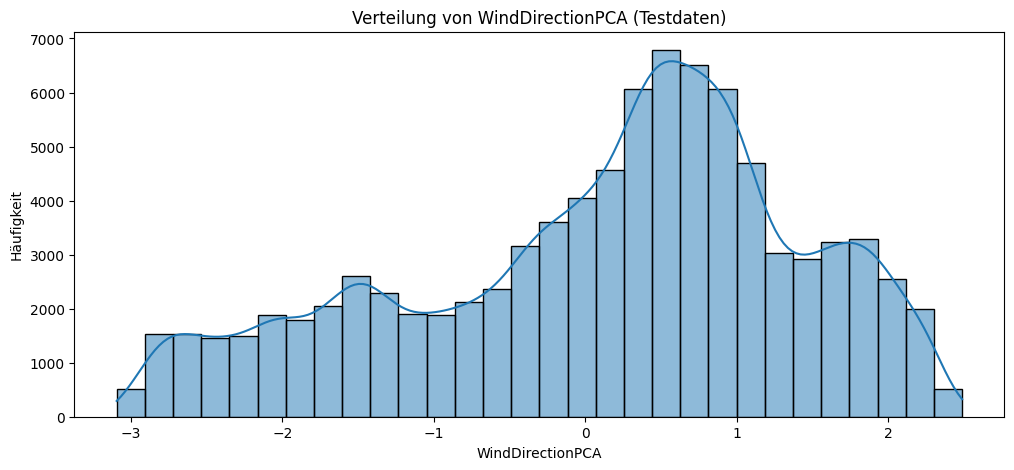

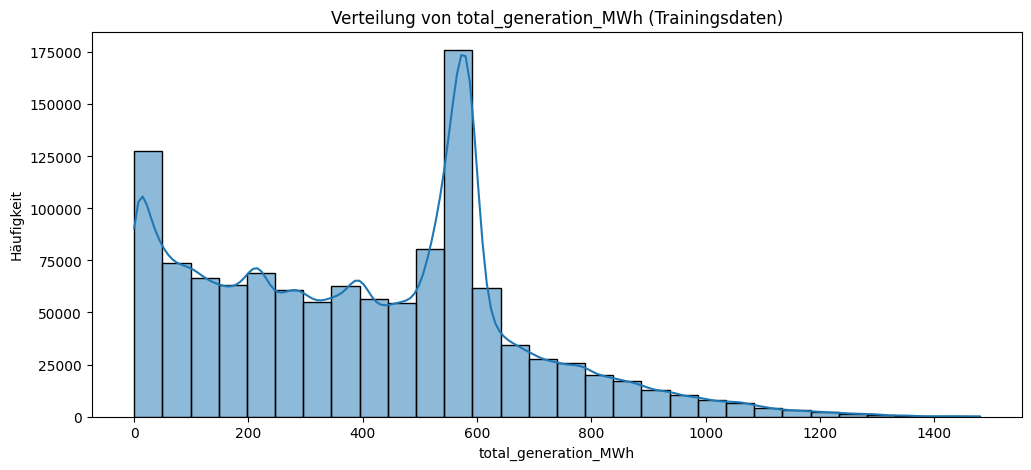

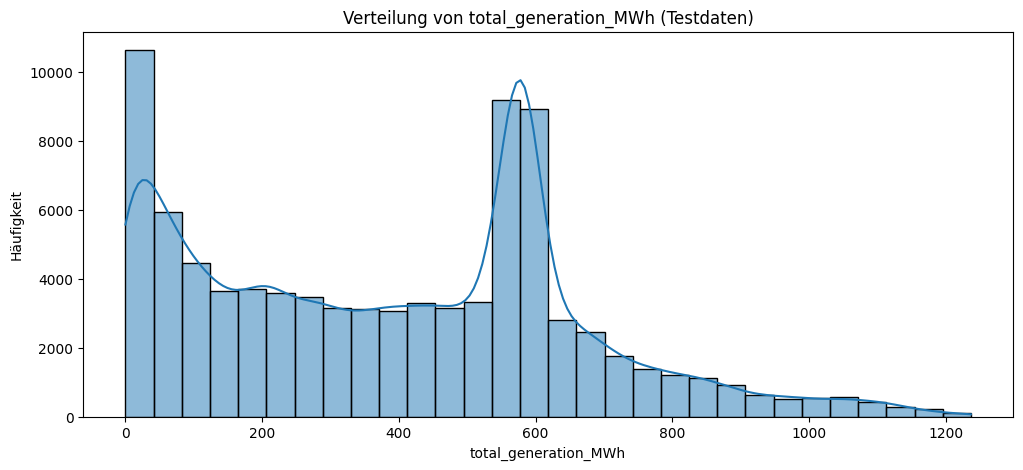

In [490]:
import seaborn as sns
import matplotlib.pyplot as plt

# Funktion zur Überprüfung der Verteilung aller Merkmale in den Trainings- und Testdaten
def plot_distributions(train_df, test_df):
    for column in train_df.columns:
        # Überprüfe, ob die Spalte numerisch ist
        if pd.api.types.is_numeric_dtype(train_df[column]):
            # Plot für Trainingsdaten
            plt.figure(figsize=(12, 5))
            sns.histplot(train_df[column], bins=30, kde=True)
            plt.title(f'Verteilung von {column} (Trainingsdaten)')
            plt.xlabel(column)
            plt.ylabel('Häufigkeit')
            plt.show()

            # Plot für Testdaten
            plt.figure(figsize=(12, 5))
            sns.histplot(test_df[column], bins=30, kde=True)
            plt.title(f'Verteilung von {column} (Testdaten)')
            plt.xlabel(column)
            plt.ylabel('Häufigkeit')
            plt.show()

# Funktion aufrufen, um die Verteilungen zu plotten
plot_distributions(df_train, df_test)


In [472]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# Funktion zur Modellierung für die Trainingsdaten
def train_models_lasso(modelling_table):
    forecast_models = dict()  # Dictionary für die trainierten Modelle
    
    # Parameter für Lasso
    alphas = [0.1, 1, 10]  # Beispiel für Regularisierungsstärken
    for idx, formula in enumerate(model_formulas):
        for quantile in range(10, 100, 10):
            # Definiere die Merkmale (X) und Zielvariable (y)
            X = modelling_table[["temp_x_solar_interaction", "SolarDownwardRadiation", 
                                  "adjusted_solar_radiation", "temp_y_solar_interaction", 
                                  "WindSpeedPCA"]]
            y = modelling_table["total_generation_MWh"]
            
            # Suche nach den besten Hyperparametern mit GridSearch
            lasso = Lasso()
            grid = GridSearchCV(lasso, {'alpha': alphas}, scoring='neg_mean_absolute_error', cv=5)
            grid.fit(X, y)
            best_model = grid.best_estimator_
            forecast_models[f"Model_{idx + 1}_q{quantile}"] = best_model
            
            # Vorhersagen für Trainingsdaten speichern
            modelling_table[f"Model_{idx + 1}_q{quantile}"] = best_model.predict(X)
            modelling_table.loc[modelling_table[f"Model_{idx + 1}_q{quantile}"] < 0, f"Model_{idx + 1}_q{quantile}"] = 0  # Negative Werte auf 0 setzen
        
    return forecast_models  # Rückgabe der trainierten Modelle

# Der Rest des Codes bleibt unverändert
# Trainiere die Modelle auf den Trainingsdaten
forecast_models = train_models_lasso(modelling_table)

# Berechne und speichere die Scores auf den Trainings- und Testdaten zusammen mit den verwendeten Features
calculate_and_save_scores(modelling_table, test_table, forecast_models, model_formulas)


c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.026e+07, tolerance: 5.810e+03

c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.959e+06, tolerance: 5.486e+03

c:\Users\Michael Jäckle\Desktop\Domainenprojekt_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.434e+

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- CloudCover
- CloudCover_lag_1h
- DA_Price
- MIP
- Model_1_q10
- ...


In [607]:
# Erstelle einen leeren DataFrame, um die Feature-Wichtigkeiten zu speichern
coefficients_df = pd.DataFrame()

# Iteriere über alle Modelle von q10 bis q90
for model_idx in range(1, len(model_formulas) + 1):  # Für alle Modelle
    for quantile in range(10, 100, 10):  # Für alle Quantile von q10 bis q90
        model_key = f"Model_{model_idx}_q{quantile}"  # Schlüssel für das Modell
        
        # Extrahiere die Koeffizienten des Modells
        model = forecast_models[model_key]
        params = model.params

        # Erstelle ein temporäres DataFrame mit den Koeffizienten
        temp_df = pd.DataFrame({
            "Feature": params.index,  # Feature-Namen
            "Coefficient": params.values,  # Koeffizienten
            "Quantile": f"q{quantile}",  # Quantil
            "Model": f"Model_{model_idx}"  # Modellnummer
        })
        
        # Füge die Koeffizienten zum Haupt-DataFrame hinzu
        coefficients_df = pd.concat([coefficients_df, temp_df], ignore_index=True)


coefficients_df.iloc[40:100]

Feature    Coefficient Quantile    Model
40   bs(humidity_wind_interaction, df=13)[9]     -71.338333      q10  Model_1
41  bs(humidity_wind_interaction, df=13)[10]    -167.601595      q10  Model_1
42  bs(humidity_wind_interaction, df=13)[11]     197.461177      q10  Model_1
43  bs(humidity_wind_interaction, df=13)[12]   -1068.273305      q10  Model_1
44               bs(wind_gradient, df=10)[0]       4.691717      q10  Model_1
45               bs(wind_gradient, df=10)[1]      10.485069      q10  Model_1
46               bs(wind_gradient, df=10)[2]     -79.651188      q10  Model_1
47               bs(wind_gradient, df=10)[3]    -389.357860      q10  Model_1
48               bs(wind_gradient, df=10)[4]   -1193.542786      q10  Model_1
49               bs(wind_gradient, df=10)[5]   -1758.834858      q10  Model_1
50               bs(wind_gradient, df=10)[6]   -2361.990786      q10  Model_1
51               bs(wind_gradient, df=10)[7]    9349.045520      q10  Model_1
52               bs(wind_gradient, df=10)[8]   59576.826355      q10  Model_1
53               bs(wind_gradient, df=10)[9]  118593.707001      q10  Model_1
54                                 Intercept       1.418228      q20  Model_1
55                  bs(CloudCover, df=15)[0]      -3.159347      q20  Model_1
56                  bs(CloudCover, df=15)[1]      -1.950765      q20  Model_1
57                  bs(CloudCover, df=15)[2]      -2.456516      q20  Model_1
58                  bs(CloudCover, df=15)[3]      -2.217448      q20  Model_1
59                  bs(CloudCover, df=15)[4]      -2.375887      q20  Model_1
60                  bs(CloudCover, df=15)[5]      -2.253019      q20  Model_1
61                  bs(CloudCover, df=15)[6]      -2.330334      q20  Model_1
62                  bs(CloudCover, df=15)[7]      -2.274489      q20  Model_1
63                  bs(CloudCover, df=15)[8]      -2.281360      q20  Model_1
64                  bs(CloudCover, df=15)[9]      -2.284552      q20  Model_1
65                 bs(CloudCover, df=15)[10]      -2.309488      q20  Model_1
66                 bs(CloudCover, df=15)[11]      -2.299237      q20  Model_1
67                 bs(CloudCover, df=15)[12]      -1.959834      q20  Model_1
68                 bs(CloudCover, df=15)[13]      -1.864468      q20  Model_1
69                 bs(CloudCover, df=15)[14]      -0.974177      q20  Model_1
70                bs(WindSpeedPCA, df=15)[0]       1.643727      q20  Model_1
71                bs(WindSpeedPCA, df=15)[1]     -50.283946      q20  Model_1
72                bs(WindSpeedPCA, df=15)[2]      56.207011      q20  Model_1
73                bs(WindSpeedPCA, df=15)[3]     192.420753      q20  Model_1
74                bs(WindSpeedPCA, df=15)[4]     461.199957      q20  Model_1
75                bs(WindSpeedPCA, df=15)[5]     919.474753      q20  Model_1
76                bs(WindSpeedPCA, df=15)[6]    1641.424700      q20  Model_1
77                bs(WindSpeedPCA, df=15)[7]    2318.463091      q20  Model_1
78                bs(WindSpeedPCA, df=15)[8]    2604.638110      q20  Model_1
79                bs(WindSpeedPCA, df=15)[9]    2525.788359      q20  Model_1
80               bs(WindSpeedPCA, df=15)[10]    2163.510590      q20  Model_1
81               bs(WindSpeedPCA, df=15)[11]    1618.123070      q20  Model_1
82               bs(WindSpeedPCA, df=15)[12]   -4031.537543      q20  Model_1
83               bs(WindSpeedPCA, df=15)[13]  -40641.835682      q20  Model_1
84               bs(WindSpeedPCA, df=15)[14] -151189.820984      q20  Model_1
85   bs(humidity_wind_interaction, df=13)[0]      -2.301145      q20  Model_1
86   bs(humidity_wind_interaction, df=13)[1]      -1.115531      q20  Model_1
87   bs(humidity_wind_interaction, df=13)[2]      -1.863468      q20  Model_1
88   bs(humidity_wind_interaction, df=13)[3]      -8.578748      q20  Model_1
89   bs(humidity_wind_interaction, df=13)[4]     -14.447471      q20  Model_1
90   bs(humidity_wind_interaction, df=13)[5]     -31.060002

In [543]:
# DataFrame nach Quantilen splitten
quantiles = coefficients_df['Quantile'].unique()  # Alle einzigartigen Quantile-Werte

# Leere Liste für die DataFrames erstellen
dfs = {}

# DataFrame in Quantil-Bereiche splitten
for quantile in quantiles:
    quantile_df = coefficients_df[coefficients_df['Quantile'] == quantile]
    dfs[quantile] = quantile_df  # Speichern in einem Dictionary

# Ausgabe der gesplitteten DataFrames
for quantile, quantile_df in dfs.items():
    print(f'DataFrame für {quantile}:')
    print(quantile_df)
    print()

DataFrame für q10:
                                  Feature   Coefficient Quantile    Model
0                               Intercept     -0.005332      q10  Model_1
1                 bs(CloudCover, df=8)[0]     -0.349926      q10  Model_1
2                 bs(CloudCover, df=8)[1]     -0.094154      q10  Model_1
3                 bs(CloudCover, df=8)[2]      0.018352      q10  Model_1
4                 bs(CloudCover, df=8)[3]      0.035741      q10  Model_1
5                 bs(CloudCover, df=8)[4]      0.154700      q10  Model_1
6                 bs(CloudCover, df=8)[5]      0.105081      q10  Model_1
7                 bs(CloudCover, df=8)[6]     -1.872508      q10  Model_1
8                 bs(CloudCover, df=8)[7]      0.771043      q10  Model_1
9   bs(adjusted_solar_radiation, df=6)[0]    -76.571876      q10  Model_1
10  bs(adjusted_solar_radiation, df=6)[1]    722.715012      q10  Model_1
11  bs(adjusted_solar_radiation, df=6)[2]  -3839.120551      q10  Model_1
12  bs(adjusted_sol

In [608]:
# DataFrame nach Quantilen splitten
quantiles = coefficients_df['Quantile'].unique()  # Alle einzigartigen Quantile-Werte

# Leere Liste für die DataFrames erstellen
dfs = {}

# DataFrame in Quantil-Bereiche splitten
for quantile in quantiles:
    quantile_df = coefficients_df[coefficients_df['Quantile'] == quantile]
    dfs[quantile] = quantile_df  # Speichern in einem Dictionary

# Mergen der DataFrames auf Basis der Feature-Spalte
merged_df = dfs[quantiles[0]].copy()  # Starte mit dem ersten Quantil

for quantile in quantiles[1:]:
    merged_df = merged_df.merge(dfs[quantile], on='Feature', suffixes=('', f'_{quantile}'), how='outer')

# Ausgabe des kombinierten DataFrames
print('Kombinierter DataFrame:')
merged_df.filter(['Feature','Coefficient','Coefficient_q20','Coefficient_q30','Coefficient_q40','Coefficient_q50','Coefficient_q60','Coefficient_q70','Coefficient_q80','Coefficient_q90']).head()

Kombinierter DataFrame:


Feature  Coefficient  Coefficient_q20  Coefficient_q30  \
0                  Intercept    -1.507917         1.418228         3.954287   
1   bs(CloudCover, df=15)[0]    -0.194245        -3.159347        -7.753380   
2  bs(CloudCover, df=15)[10]    -0.201539        -2.309488        -5.427949   
3  bs(CloudCover, df=15)[11]    -0.155432        -2.299237        -5.427267   
4  bs(CloudCover, df=15)[12]    -0.146022        -1.959834        -4.102783   

   Coefficient_q40  Coefficient_q50  Coefficient_q60  Coefficient_q70  \
0         4.192230         4.199912         4.529665        -1.493566   
1       -10.611704        -9.243570        -8.475435        -7.554516   
2        -7.416459        -3.034699         3.443334         7.747409   
3        -3.469785         1.243530         4.272294         8.951903   
4        -3.840601         1.007811         6.568779        10.299029   

   Coefficient_q80  Coefficient_q90  
0        -7.914296         2.479562  
1        -0.527254         4.910308  
2        15.305116        19.736106  
3        15.510612        19.676318  
4        17.333374        21.470304

In [609]:
merged_df_T = merged_df.T
new_headers = merged_df_T.iloc[0]  # Die erste Zeile extrahieren
merged_df_T.columns = new_headers  # Neue Header setzen

# # Den DataFrame ab der zweiten Zeile neu erstellen
merged_df_T = merged_df_T[1:].reset_index(drop=True) 
# merged_df_T

# # Mit loc einen Bereich von Zeilen auswählen (1, 10) mit Schritt von 2
start = 0  # Startindex
end = 27   # Endindex (exklusive)
step = 3  # Schrittgröße

selected_rows = merged_df_T.loc[range(start, end, step)]
# selected_rows
selected_rows['Nummer'] = range(1, len(selected_rows) + 1)
selected_rows = selected_rows.set_index('Nummer')
selected_rows

Feature Intercept bs(CloudCover, df=15)[0] bs(CloudCover, df=15)[10]  \
Nummer                                                                 
1       -1.507917                -0.194245                 -0.201539   
2        1.418228                -3.159347                 -2.309488   
3        3.954287                 -7.75338                 -5.427949   
4         4.19223               -10.611704                 -7.416459   
5        4.199912                 -9.24357                 -3.034699   
6        4.529665                -8.475435                  3.443334   
7       -1.493566                -7.554516                  7.747409   
8       -7.914296                -0.527254                 15.305116   
9        2.479562                 4.910308                 19.736106   

Feature bs(CloudCover, df=15)[11] bs(CloudCover, df=15)[12]  \
Nummer                                                        
1                       -0.155432                 -0.146022   
2                       -2.299237                 -1.959834   
3                       -5.427267                 -4.102783   
4                       -3.469785                 -3.840601   
5                         1.24353                  1.007811   
6                        4.272294                  6.568779   
7                        8.951903                 10.299029   
8                       15.510612                 17.333374   
9                       19.676318                 21.470304   

Feature bs(CloudCover, df=15)[13] bs(CloudCover, df=15)[14]  \
Nummer                                                        
1                       -0.130594                 -0.144797   
2                       -1.864468                 -0.974177   
3                       -4.993303                 -0.770486   
4                       -3.428589                  0.569318   
5                        2.035787                  5.825286   
6                        7.198333                   9.60939   
7                       12.097031                 12.892653   
8                       18.255904                 19.331503   
9                       22.095496                 23.635026   

Feature bs(CloudCover, df=15)[1] bs(CloudCover, df=15)[2]  \
Nummer                                                      
1                      -0.093595                -0.144309   
2                      -1.950765                -2.456516   
3                      -4.631513                -5.805438   
4                      -6.229801                -8.123592   
5                      -6.161827                -7.546775   
6                      -4.802133                -6.571296   
7                      -3.869234                -2.411715   
8                       1.231052                  4.27281   
9                       5.682567                10.658566   

Feature bs(CloudCover, df=15)[3]  ... bs(wind_gradient, df=10)[0]  \
Nummer                            ...                               
1                      -0.123362  ...                    4.691717   
2                      -2.217448  ...                   40.491674   
3                       -5.22454  ...                   47.023073   
4                      -7.049878  ...                    35.77588   
5                      -6.466156  ...                   22.005333   
6                      -4.035875  ...                   22.849034   
7                      -0.313084  ...                   17.864423   
8                       5.767308  ...                 -218.874278   
9                      11.866522  ...                 -408.174322   

Feature bs(wind_gradient, df=10)[1] bs(wind_gradient, df=10)[2]  \
Nummer                                                            
1                         10.485069                  -79.651188   
2                        -24.567925                 -203.665155   
3                        -92.999554                 -364.441756   
4                       -118.105337                 

In [610]:
def highlight_values(s):
    is_max = s == s.max()
    is_min = s == s.min()
    max_distance = s.abs().max()
    
    return [
        'background-color: #f0f0f0' if abs(val) == max_distance else 
        'background-color: #d3d3d3' if max_val else 
        'background-color: #d3d3d3' if min_val else 
        
        '' 
        for max_val, min_val, val in zip(is_max, is_min, s)
    ]

# DataFrame formatieren und maximalen Wert hervorheben
selected_rows_f = selected_rows.style.apply(highlight_values)
selected_rows_f


In [399]:
new_headers = merged_df_T.iloc[0]
new_headers

0                                  Intercept
1       bs(SolarDownwardRadiation, df=10)[0]
2       bs(SolarDownwardRadiation, df=10)[1]
3       bs(SolarDownwardRadiation, df=10)[2]
4       bs(SolarDownwardRadiation, df=10)[3]
5       bs(SolarDownwardRadiation, df=10)[4]
6       bs(SolarDownwardRadiation, df=10)[5]
7       bs(SolarDownwardRadiation, df=10)[6]
8       bs(SolarDownwardRadiation, df=10)[7]
9       bs(SolarDownwardRadiation, df=10)[8]
10      bs(SolarDownwardRadiation, df=10)[9]
11                bs(WindSpeedPCA, df=10)[0]
12                bs(WindSpeedPCA, df=10)[1]
13                bs(WindSpeedPCA, df=10)[2]
14                bs(WindSpeedPCA, df=10)[3]
15                bs(WindSpeedPCA, df=10)[4]
16                bs(WindSpeedPCA, df=10)[5]
17                bs(WindSpeedPCA, df=10)[6]
18                bs(WindSpeedPCA, df=10)[7]
19                bs(WindSpeedPCA, df=10)[8]
20                bs(WindSpeedPCA, df=10)[9]
21    bs(adjusted_solar_radiation, df=10)[0]
22    bs(a

In [344]:
import pandas as pd
import re

# Beispiel DataFrame (ersetze dies durch dein tatsächliches df_2)
# df_2 = pd.DataFrame({'Feature_min': ['bs(RelativeHumidity, df=3)[0]', 'bs(RelativeHumidity, df=3)[1]', 'bs(OtherFeature, df=3)[0]']})

# Funktion zum Extrahieren des relevanten Teils
def extract_feature_name(feature):
    match = re.search(r'bs\((\w+), df=\d+\)\[\d+\]', feature)
    return match.group(1) if match else feature

# Eindeutige Namen aus der Spalte 'Feature_min' extrahieren und umwandeln
unique_feature_min = coefficients_df['Feature'].apply(extract_feature_name).unique()

# Umwandeln in eine Liste, falls gewünscht
unique_feature_min_list = unique_feature_min.tolist()

# Ausgabe der eindeutigen Namen
print(unique_feature_min_list)

['Intercept', 'RelativeHumidity', 'temp_hornsea', 'hours_after', 'CloudCover', 'SolarDownwardRadiation', 'temp_solar', 'month', 'hour', 'adjusted_solar_radiation', 'temp_x_solar_interaction', 'temp_y_solar_interaction', 'wind_interaction', 'wind_interaction_100', 'humidity_wind_interaction', 'wind_gradient', 'CloudCover_lag_1h', 'WindSpeedPCA', 'WindDirectionPCA']


In [350]:
# Funktion zur Extraktion und Anzeige der P-Werte
def extract_p_values(forecast_models):
    p_values_dict = {}
    
    for model_key, model in forecast_models.items():
        # P-Werte aus dem Modell extrahieren
        p_values = model.pvalues
        p_values_dict[model_key] = p_values
    
    return p_values_dict

# Nach dem Training der Modelle die P-Werte extrahieren
p_values = extract_p_values(forecast_models)

# P-Werte anzeigen
for model_key, p_vals in p_values.items():
    print(f"P-Werte für {model_key}:")
    print(p_vals)


P-Werte für Model_1_q10:
Intercept                    3.877138e-03
bs(hours_after, df=8)[0]     1.329286e-01
bs(hours_after, df=8)[1]     7.398298e-01
bs(hours_after, df=8)[2]     2.005770e-02
bs(hours_after, df=8)[3]     9.700893e-07
                                 ...     
bs(WindSpeedPCA, df=8)[3]    8.913022e-01
bs(WindSpeedPCA, df=8)[4]    1.728292e-01
bs(WindSpeedPCA, df=8)[5]    3.094277e-03
bs(WindSpeedPCA, df=8)[6]    6.947334e-03
bs(WindSpeedPCA, df=8)[7]    8.411407e-01
Length: 81, dtype: float64
P-Werte für Model_1_q20:
Intercept                    0.204521
bs(hours_after, df=8)[0]     0.534327
bs(hours_after, df=8)[1]     0.265510
bs(hours_after, df=8)[2]     0.099274
bs(hours_after, df=8)[3]     0.000010
                               ...   
bs(WindSpeedPCA, df=8)[3]    0.709432
bs(WindSpeedPCA, df=8)[4]    0.017861
bs(WindSpeedPCA, df=8)[5]    0.000010
bs(WindSpeedPCA, df=8)[6]    0.000071
bs(WindSpeedPCA, df=8)[7]    0.976716
Length: 81, dtype: float64
P-Werte für Mode

In [352]:
# Korrelation zwischen Features und Zielwert berechnen
correlation_matrix = modelling_table.corr()
target_correlation = correlation_matrix['total_generation_MWh'].sort_values(ascending=False)

# Korrelationsergebnisse anzeigen
print("Korrelation mit dem Zielwert 'total_generation_MWh':")
print(target_correlation)


Korrelation mit dem Zielwert 'total_generation_MWh':
total_generation_MWh           1.000000
Model_1_q50                    0.910278
Model_1_q40                    0.905813
Model_1_q60                    0.896922
Model_1_q30                    0.892824
Model_1_q70                    0.883089
Model_1_q20                    0.874662
Model_1_q80                    0.869258
Model_1_q10                    0.859891
Model_1_q90                    0.851534
Solar_MW                       0.733547
Solar_MWh_credit               0.733547
temp_x_solar_interaction       0.688287
SolarDownwardRadiation         0.688105
adjusted_solar_radiation       0.687649
temp_y_solar_interaction       0.676740
Wind_MW                        0.614069
Wind_MWh_credit                0.613478
WindSpeed:100                  0.372567
WindSpeedPCA                   0.369398
WindSpeed                      0.360714
wind_gradient                  0.354700
humidity_wind_interaction      0.350028
temp_solar                 

In [283]:
coefficients_df

Feature   Coefficient Quantile    Model  \
0                        Intercept    128.182219      q10  Model_1   
1    bs(RelativeHumidity, df=3)[0]     52.994717      q10  Model_1   
2    bs(RelativeHumidity, df=3)[1]   -177.987503      q10  Model_1   
3    bs(RelativeHumidity, df=3)[2]     37.037445      q10  Model_1   
4        bs(temp_hornsea, df=3)[0]     51.553203      q10  Model_1   
..                             ...           ...      ...      ...   
490      bs(WindSpeedPCA, df=3)[1] -39987.622564      q90  Model_1   
491      bs(WindSpeedPCA, df=3)[2] -84779.526147      q90  Model_1   
492  bs(WindDirectionPCA, df=3)[0]   -427.937847      q90  Model_1   
493  bs(WindDirectionPCA, df=3)[1]   -350.790905      q90  Model_1   
494  bs(WindDirectionPCA, df=3)[2]   -161.270551      q90  Model_1   

         bs_component  
0                 NaN  
1    RelativeHumidity  
2    RelativeHumidity  
3    RelativeHumidity  
4        temp_hornsea  
..                ...  
490      WindSpeedPCA  
491      WindSpeedPCA  
492  WindDirectionPCA  
493  WindDirectionPCA  
494  WindDirectionPCA  

[495 rows x 5 columns]

In [108]:
forecast_models

{'Model_1_q10': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15da7d5f470>,
 'Model_1_q20': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15da7cad400>,
 'Model_1_q30': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15d9ab9dd00>,
 'Model_1_q40': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15da7d5f890>,
 'Model_1_q50': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15db1e7b4d0>,
 'Model_1_q60': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15d9addeab0>,
 'Model_1_q70': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15da7d5b950>,
 'Model_1_q80': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15d9addda00>,
 'Model_1_q90': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x15da5ee3f80>}

In [27]:
loaded_models = load_models("quantile_models.pkl")

Modelle wurden aus 'quantile_models.pkl' geladen.


In [29]:
# Überprüfen der Datentypen
print(df_full.dtypes)

# Vorbereiten der Features (X) und Zielvariablen (y)
X = df_full.select_dtypes(include=['float64', 'int64'])  # Nur numerische Spalten
X = X.drop(columns=["total_generation_MWh",], errors='ignore')  # Zielvariable entfernen
y = df_full["total_generation_MWh"]

X = X.dropna()
y = y[X.index] 

# Fehlende Werte mit dem Mittelwert ersetzen
imputer = SimpleImputer(strategy='mean')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Aufteilen der Daten in Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lasso-Modell initialisieren
lasso_model = Lasso(alpha=0.1)  # Alpha kann je nach Bedarf angepasst werden

# Modell trainieren
lasso_model.fit(X_train, y_train)

# Vorhersagen auf Testdaten machen
predictions = lasso_model.predict(X_test)

# Ergebnisse ausgeben
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': predictions
})

print(results_df)


reference_time            datetime64[ns, UTC]
valid_time                datetime64[ns, UTC]
CloudCover                            float32
SolarDownwardRadiation                float64
Temperature_x                         float32
RelativeHumidity                      float32
Temperature_y                         float32
WindDirection                         float32
WindDirection:100                     float32
WindSpeed                             float32
WindSpeed:100                         float32
dtm                       datetime64[ns, UTC]
Wind_MWh_credit                       float64
Solar_MWh_credit                      float64
forcast_hours                         float64
year                                    int32
month                                   int32
day                                     int32
hour                                    int32
total_generation_MWh                  float64
dtype: object
             Actual   Predicted
726307   580.003510  580.012482
30

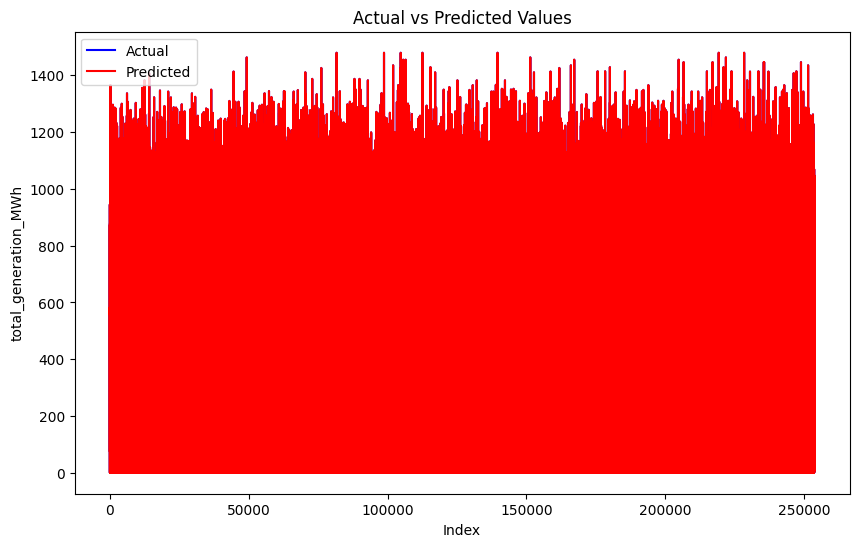

In [30]:
import matplotlib.pyplot as plt

# Plotten der tatsächlichen und vorhergesagten Werte
plt.figure(figsize=(10, 6))

# Tatsächliche Werte plotten
plt.plot(results_df['Actual'].values, label='Actual', color='blue')

# Vorhergesagte Werte plotten
plt.plot(results_df['Predicted'].values, label='Predicted', color='red')

# Titel und Beschriftungen hinzufügen
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('total_generation_MWh')

# Legende anzeigen
plt.legend()

# Plot anzeigen
plt.show()


In [24]:
# Speichern der trainierten Modelle in einer Datei
with open('trained_forecast_models.pkl', 'wb') as file:
    pickle.dump(forecast_models, file)

print("Die trainierten Modelle wurden in 'trained_forecast_models.pkl' gespeichert.")


Die trainierten Modelle wurden in 'trained_forecast_models.pkl' gespeichert.


In [493]:
df_train.columns   ['reference_time', 'valid_time','dtm', 'MIP', 'Solar_MW','boa_MWh',]

Index(['reference_time', 'valid_time', 'RelativeHumidity', 'temp_hornsea',
       'WindDirection', 'WindDirection:100', 'WindSpeed', 'WindSpeed:100',
       'hours_after', 'CloudCover', 'SolarDownwardRadiation', 'temp_solar',
       'dtm', 'MIP', 'Solar_MW', 'Solar_capacity_mwp',
       'Solar_installedcapacity_mwp', 'Wind_MW', 'SS_Price', 'boa_MWh',
       'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year', 'month',
       'day', 'hour', 'adjusted_solar_radiation', 'temp_x_solar_interaction',
       'temp_y_solar_interaction', 'wind_interaction', 'wind_interaction_100',
       'humidity_wind_interaction', 'wind_gradient', 'CloudCover_lag_1h',
       'cloud_cover_change', 'WindSpeedPCA', 'WindDirectionPCA',
       'total_generation_MWh'],
      dtype='object')

In [495]:
df_train_c = df_train.drop(['reference_time', 'valid_time','dtm', 'MIP', 'Solar_MW','boa_MWh'], axis=1)
df_train_c.head()

RelativeHumidity  temp_hornsea  WindDirection  WindDirection:100  \
0         85.213753     15.416670      61.588081          62.085171   
1         85.012268     15.412510      61.203667          61.726974   
2         84.810783     15.408349      60.819256          61.368782   
3         84.357895     15.451218      60.511024          61.111046   
4         83.904999     15.494086      60.202793          60.853313   

   WindSpeed  WindSpeed:100  hours_after  CloudCover  SolarDownwardRadiation  \
0  10.043627      11.802604          0.0    0.450405                     0.0   
1   9.905537      11.648818          0.5    0.472211                     0.0   
2   9.767446      11.495032          1.0    0.494018                     0.0   
3   9.631038      11.354128          1.5    0.520214                     0.0   
4   9.494630      11.213223          2.0    0.546410                     0.0   

   temp_solar  ...  temp_y_solar_interaction  wind_interaction  \
0   13.646173  ...                       0.0          3.226282   
1   13.658508  ...                       0.0         -0.568167   
2   13.670843  ...                       0.0         -4.176249   
3   13.732101  ...                       0.0         -6.565115   
4   13.793360  ...                       0.0         -8.274620   

   wind_interaction_100  humidity_wind_interaction  wind_gradient  \
0              8.662477                 855.855103     118.540947   
1              5.233149                 842.092163     115.387794   
2              1.235912                 828.384705     112.277100   
3             -1.696862                 812.454041     109.352036   
4             -4.446476                 796.646912     106.465401   

   CloudCover_lag_1h  cloud_cover_change  WindSpeedPCA  WindDirectionPCA  \
0                NaN                 NaN      0.777202         -2.159108   
1           0.450405            0.021806      0.729639         -2.164935   
2           0.472211            0.021806      0.682076         -2.170762   
3           0.494018            0.026196      0.636702         -2.175203   
4           0.520214            0.026196      0.591328         -2.179644   

   total_generation_MWh  
0               498.142  
1               478.788  
2               470.522  
3               482.183  
4               459.216  

[5 rows x 33 columns]

In [520]:
df_train_c.columns

Index(['RelativeHumidity', 'temp_hornsea', 'WindDirection',
       'WindDirection:100', 'WindSpeed', 'WindSpeed:100', 'hours_after',
       'CloudCover', 'SolarDownwardRadiation', 'temp_solar',
       'Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'Wind_MW',
       'SS_Price', 'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year',
       'month', 'day', 'hour', 'adjusted_solar_radiation',
       'temp_x_solar_interaction', 'temp_y_solar_interaction',
       'wind_interaction', 'wind_interaction_100', 'humidity_wind_interaction',
       'wind_gradient', 'CloudCover_lag_1h', 'cloud_cover_change',
       'WindSpeedPCA', 'WindDirectionPCA', 'total_generation_MWh'],
      dtype='object')

In [525]:
df_train_c_f1 = df_train_c.filter(['RelativeHumidity', 'temp_hornsea', 'WindDirection',
       'WindDirection:100', 'WindSpeed', 'WindSpeed:100', 'hours_after',         'SS_Price', 'DA_Price', 'Wind_MWh_credit', 'Solar_MWh_credit', 'year',
       'CloudCover', 'SolarDownwardRadiation', 'temp_solar', 'Solar_MWh_credit','Solar_capacity_mwp', 'Solar_installedcapacity_mwp', 'total_generation_MWh'])

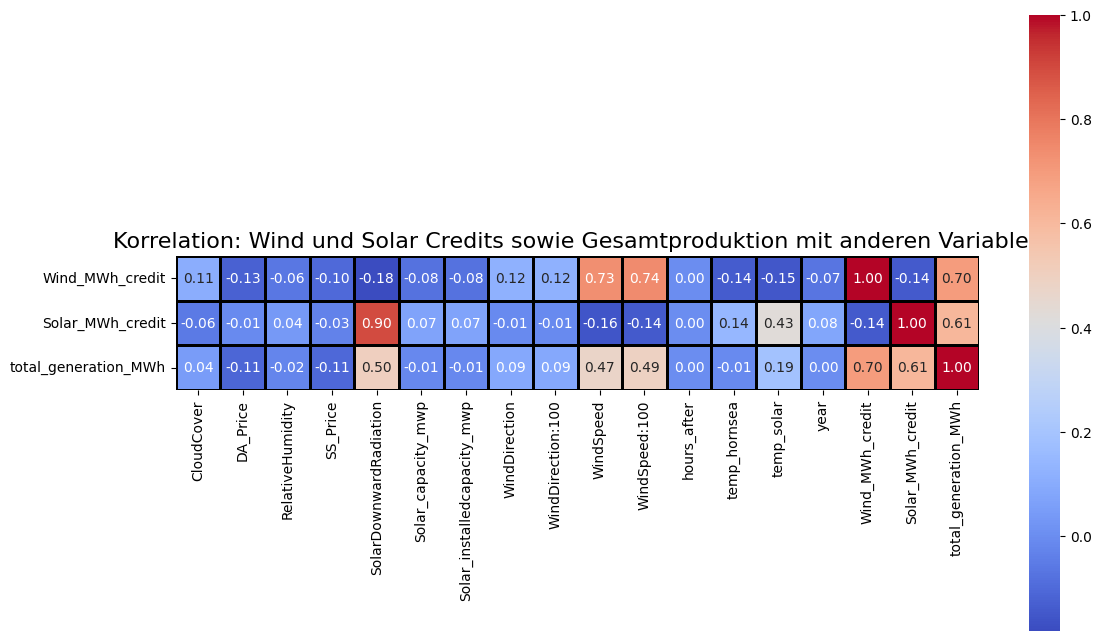

In [526]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Angenommen, df_train ist dein DataFrame

# Definiere die Zielspalten für die Analyse
target_columns = ['Wind_MWh_credit', 'Solar_MWh_credit', 'total_generation_MWh']

# Wähle alle Spalten aus, die nicht in den Zielspalten sind
non_target_columns = df_train_c_f1.columns.difference(target_columns).tolist()  # Alle Spalten außer den Zielspalten

# Erstelle die Korrelationsmatrix für die Zielspalten und die anderen
correlation_matrix = df_train[non_target_columns + target_columns].corr()

# Setze die Größe der Abbildung
plt.figure(figsize=(12, 8))  # Breitere Abbildung

# Erstelle die Heatmap für die Zielspalten
sns.heatmap(correlation_matrix.loc[target_columns, :], 
            annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, 
            linewidths=1, linecolor='black')  # Schwarze Linien für bessere Sichtbarkeit

# Titel hinzufügen
plt.title('Korrelation: Wind und Solar Credits sowie Gesamtproduktion mit anderen Variablen', fontsize=16)
plt.tight_layout()  # Für bessere Anpassung der Layouts
plt.show()


In [528]:
df_train_c_f2 = df_train_c.filter(['month', 'day', 'hour', 'adjusted_solar_radiation',
       'temp_x_solar_interaction', 'temp_y_solar_interaction',
       'wind_interaction', 'wind_interaction_100', 'humidity_wind_interaction',
       'wind_gradient', 'CloudCover_lag_1h', 'cloud_cover_change',
       'WindSpeedPCA', 'WindDirectionPCA','Solar_MWh_credit','Solar_capacity_mwp', 'total_generation_MWh'])

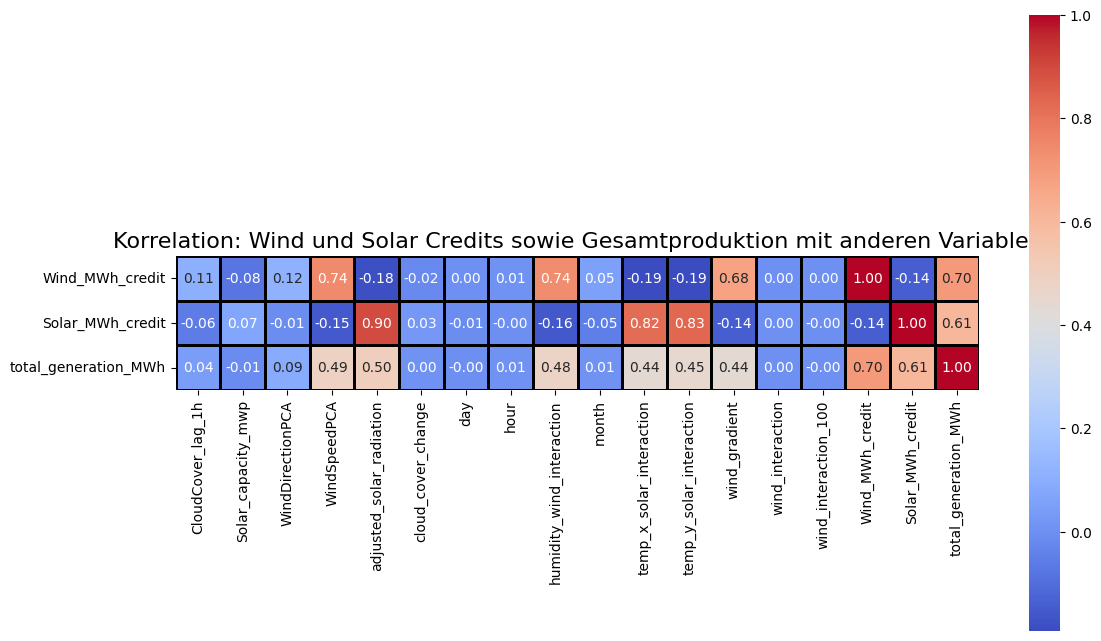

In [529]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Angenommen, df_train ist dein DataFrame

# Definiere die Zielspalten für die Analyse
target_columns = ['Wind_MWh_credit', 'Solar_MWh_credit', 'total_generation_MWh']

# Wähle alle Spalten aus, die nicht in den Zielspalten sind
non_target_columns = df_train_c_f2.columns.difference(target_columns).tolist()  # Alle Spalten außer den Zielspalten

# Erstelle die Korrelationsmatrix für die Zielspalten und die anderen
correlation_matrix = df_train[non_target_columns + target_columns].corr()

# Setze die Größe der Abbildung
plt.figure(figsize=(12, 8))  # Breitere Abbildung

# Erstelle die Heatmap für die Zielspalten
sns.heatmap(correlation_matrix.loc[target_columns, :], 
            annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, 
            linewidths=1, linecolor='black')  # Schwarze Linien für bessere Sichtbarkeit

# Titel hinzufügen
plt.title('Korrelation: Wind und Solar Credits sowie Gesamtproduktion mit anderen Variablen', fontsize=16)
plt.tight_layout()  # Für bessere Anpassung der Layouts
plt.show()


In [ ]:
'adjusted_solar_radiation', 'temp_solar','SolarDownwardRadiation', 'wind_interaction',